# 0 Libraries

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
import os
import shutil
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats.mstats import winsorize
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import t
import collections
import pandas as pd
import numpy as np
from tqdm import tqdm  # Import tqdm for progress tracking

from keras_tuner.tuners import Hyperband, RandomSearch, GridSearch
from keras_tuner import HyperModel
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, Embedding, Flatten, concatenate, RepeatVector
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import statsmodels.api as sm
from urllib3.exceptions import NotOpenSSLWarning

# Suppress specific categories of warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=NotOpenSSLWarning)
warnings.filterwarnings("ignore", message="Workbook contains no default style, apply openpyxl's default")

import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit


# Set a random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Set seed for reproducibility across numpy and TensorFlow
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

# 1 Introduction

This paper is going to forecast intraday vol - minutely log range? or maybe i try to predict 5 minute vol from minutely , resample to quadratic variation or whateva
idk the minutely seems to be working, mayb i just try to build on this instead of complicating it ? does try to see if the commmonality methodologies applied works here as well and then see if i can leverage that for minutely 


this paper uses 5 minute vol sampling for daily RV, using diffwerent models. 


maybe i split the data set into 3 sets so i can do the confidence intervals and that test statistic thingy , now i need to do hyperparameter tuning 

# 2 Data Loading and Preprocessing

## 2.1 Data Importing

In [3]:
file_path = '/Users/chesneycheyenne/Coding/Advanced Machine Learning/data/EURUSD_M30.csv'

eurusd = pd.read_csv(file_path, sep='\t')

# rename columns to open high low close volume
eurusd.columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'nil']

eurusd = eurusd.drop(columns=['Volume','nil'])

eurusd.index = pd.to_datetime(eurusd.index)
print(eurusd)

                        Open     High      Low    Close
2008-03-20 03:30:00  1.55818  1.55988  1.55771  1.55945
2008-03-20 04:00:00  1.55959  1.56074  1.55909  1.56046
2008-03-20 04:30:00  1.56055  1.56079  1.55915  1.55955
2008-03-20 05:00:00  1.55950  1.55981  1.55838  1.55867
2008-03-20 05:30:00  1.55876  1.55960  1.55829  1.55943
...                      ...      ...      ...      ...
2024-03-28 19:30:00  1.07884  1.07892  1.07867  1.07879
2024-03-28 20:00:00  1.07878  1.07880  1.07849  1.07874
2024-03-28 20:30:00  1.07876  1.07887  1.07864  1.07883
2024-03-28 21:00:00  1.07897  1.07904  1.07849  1.07888
2024-03-28 21:30:00  1.07887  1.07901  1.07881  1.07893

[200000 rows x 4 columns]


## 2.2 Feature Engineering

In [4]:
eurusd['log_returns'] = np.log(eurusd['Close'] / eurusd['Close'].shift(1))
# Extract the date and the minute of the day
eurusd['date'] = eurusd.index.date
eurusd['time'] = eurusd.index.time

eurusd['squared_return'] = eurusd['log_returns']  ** 2

# drop nan from eurusd
eurusd.dropna(inplace=True)

daily_mean_squared_return = eurusd['squared_return'].resample('D').sum()
standardized_volatility = daily_mean_squared_return 

# print(len(daily_mean_squared_return))

# Drop weekends
standardized_volatility = standardized_volatility[standardized_volatility.index.dayofweek < 5]

# Identify dates where the value is exactly zero
dates_with_zero = standardized_volatility[standardized_volatility == 0].index

# print(dates_with_zero)
#drop zero values 
standardized_volatility = standardized_volatility[standardized_volatility > 0]

daily_volatility = np.log(standardized_volatility)

daily_volatility.index = daily_volatility.index.date

# do fill the Nan values with the mean of the series
Realized_vol = daily_volatility

print(f'number of data points: {len(Realized_vol)}')


number of data points: 4179


## 2.3 Data Visualization 

In [5]:
print(Realized_vol.head())

2008-03-20    -9.937852
2008-03-21   -11.318393
2008-03-24   -10.208720
2008-03-25    -9.939550
2008-03-26    -9.602125
Name: squared_return, dtype: float64


In [6]:
print(Realized_vol.tail())

2024-03-22   -11.515223
2024-03-25   -12.238184
2024-03-26   -12.029907
2024-03-27   -12.195270
2024-03-28   -11.383350
Name: squared_return, dtype: float64


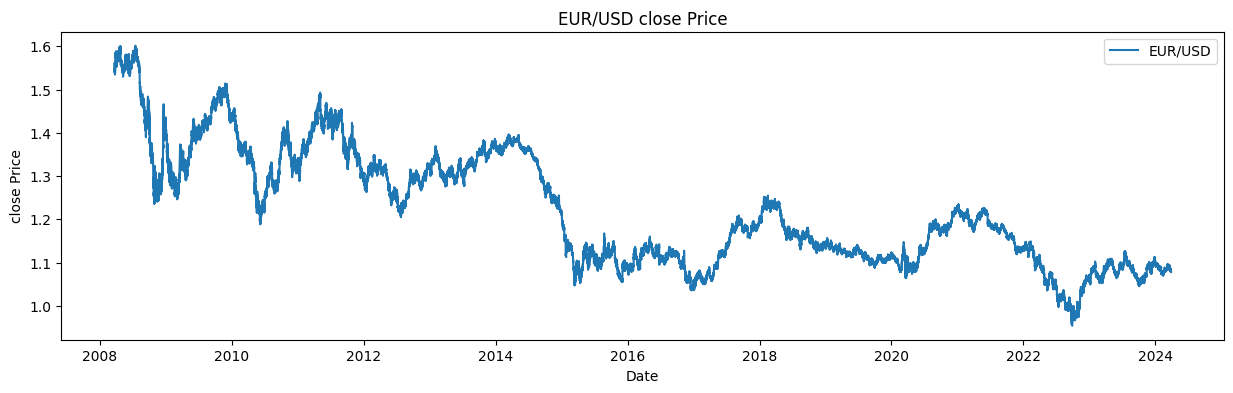

In [31]:
# Step 2: Visualize the Data
plt.figure(figsize=(15, 4))
plt.plot(eurusd['Close'], label='EUR/USD')
plt.title('EUR/USD close Price')
plt.xlabel('Date')
plt.ylabel('close Price')
plt.legend()

In [32]:
# Winsorize the data
Realized_vol_winsorized = winsorize(Realized_vol, limits=[0.001, 0.001])
RV = pd.Series(Realized_vol_winsorized, index=Realized_vol.index)

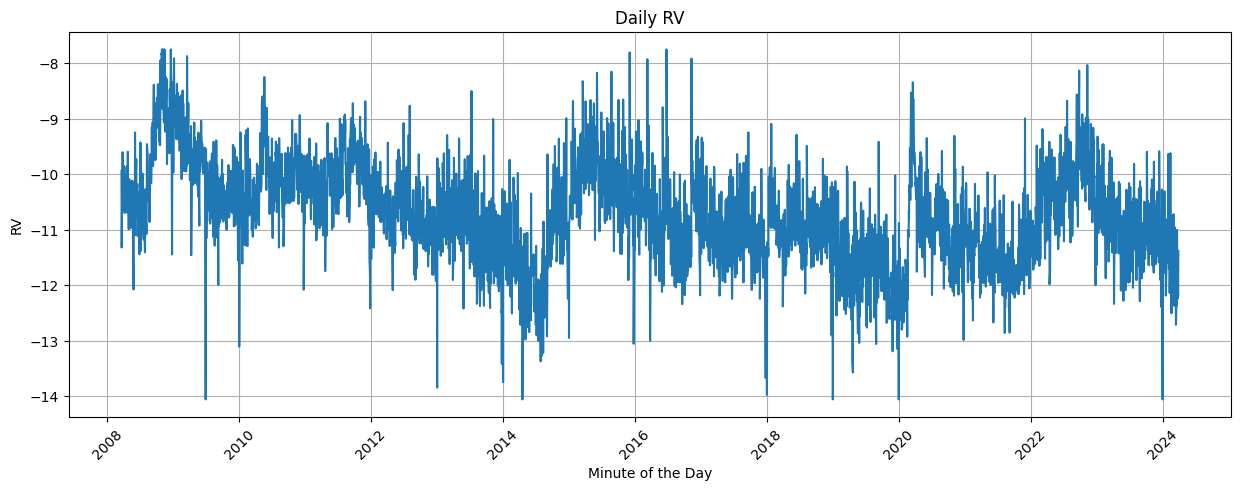

In [33]:
plt.figure(figsize=(15, 5))
plt.plot(RV)
plt.title('Daily RV')
plt.xlabel('Minute of the Day')
plt.ylabel('RV')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 3 Train-Test Split

## 3.1 Data Prep

This function prepares the time series data for LSTM model training with Keras, including a method for cross-validation and a seperate holdout set for final evaluation.

1. Reshape and standardize the data
2. Split the data into cross-validation dataset and holdout dataset based on the specified holdout ratio
3. Generates training/testing indices to split data into train and test sets
4. Scale the data to prevent information leakage from the test set into the model during training 
5. Create time series generators for both training and testing datasets, which help in feeding the data into an LSTM model in a way that respects the temporal nature of the data
6. Prepare a generator for the holdout set using the scaling parameters from the last training set of the cross-validation process


\
Key Points:
- Data Standardization: consider changing to MinMaxScaler instead , maybe more appropriate
- Batch Size: Smaller batch sizes lead to faster convergence but might be more noisy
- Time Window: Determines the number of past observations to predict future values. Too small might not capture relevant patterns, too large might introduce noise

\
Usage:
- Cross Validation: Use 'windows' list to train and validate the model across different time splits. Iterate over 'windows', train the model on each 'train_generator' and validate it on the corresponding 'test_generator' and record performance metrics for each split

- Hyper parameter Tuning: Based on the performance metrics from the CV phase, adjust the model's hyperparameters. This can involve changing the LSTM architecture (number of layers, number of units per layers), learning rate, batch size, time window size. Repeat the CV phase as needed until optimal set of hyperparameters identified. 

- Final Evaluation: Once you have selected the best hyperparameters, you can evaluate your model on the holdout_generator. This set should only be used once to assess the model's performance, providing an unbiased estimate of how well your model is expected to perform on unseen data.

In [34]:
# Assuming 'RV' is your time series data
RV_df = RV.to_frame(name='RV_daily')  # Convert the RV Series into a DataFrame
RV_df['RV_weekly'] = RV_df['RV_daily'].rolling(window=5).mean()
RV_df['RV_monthly'] = RV_df['RV_daily'].rolling(window=21).mean()
RV_df['RV_daily_tomorrow'] = RV_df['RV_daily'].shift(-1)
RV_df.index = pd.to_datetime(RV_df.index)
RV_df['weekday'] = RV_df.index.weekday  # Monday=0, Sunday=6
RV_df['month'] = RV_df.index.month 

# Drop rows with NaN values
RV_df.dropna(inplace=True)


# Split data into training, validation, and holdout sets
train_size = int(len(RV_df) * 0.70)
val_size = int(len(RV_df) * 0.15)
holdout_size = len(RV_df) - train_size - val_size

train_data = RV_df.iloc[:train_size]
val_data = RV_df.iloc[train_size:train_size + val_size]
holdout_data = RV_df.iloc[train_size + val_size:]



print(f"The training set consists of {len(train_data)} data points from {train_data.index[0].date()} to {train_data.index[-1].date()}.")
print(f"The validation set consists of {len(val_data)} data points from {val_data.index[0].date()} to {val_data.index[-1].date()}.")
print(f"The holdout set consists of {len(holdout_data)} data points from {holdout_data.index[0].date()} to {holdout_data.index[-1].date()}.")


The training set consists of 2910 data points from 2008-04-17 to 2019-06-13.
The validation set consists of 623 data points from 2019-06-14 to 2021-11-03.
The holdout set consists of 625 data points from 2021-11-04 to 2024-03-27.


These are panda series of just the pure Daily Realized Volatilities 

In [35]:
train_rv = train_data['RV_daily']
val_rv = val_data['RV_daily']
holdout_rv = holdout_data['RV_daily']

## 3.2 Metrics 

In [36]:
# DEFINE MEAN SQUARED ERROR FUNCTION
def MSE(y_true, y_pred):
    """
    Compute Mean Squared Error between two arrays.
    """
    return np.mean((y_true - y_pred) ** 2)

def q_like(y_true, y_pred):
    """
    Calculate the Quasi-likelihood (QLIKE).
    
    :param actual: numpy array of actual values.
    :param predicted: numpy array of predicted values.
    :return: QLIKE value.
    """
    ratio = y_true / y_pred
    return np.mean(ratio - np.log(ratio) - 1)

In [37]:
# Purpose  : Implement the Diebold-Mariano Test (DM test) to compare 
#            forecast accuracy
# Input    : 1) actual_lst: the list of actual values
#            2) pred1_lst : the first list of predicted values
#            3) pred2_lst : the second list of predicted values
#            4) h         : the number of stpes ahead
#            5) crit      : a string specifying the criterion 
#                             i)  MSE : the mean squared error
#                            ii)  MAD : the mean absolute deviation
#                           iii) MAPE : the mean absolute percentage error
#                            iv) poly : use power function to weigh the errors
#            6) poly      : the power for crit power 
#                           (it is only meaningful when crit is "poly")
# Condition: 1) length of actual_lst, pred1_lst and pred2_lst is equal
#            2) h must be an integer and it must be greater than 0 and less than 
#               the length of actual_lst.
#            3) crit must take the 4 values specified in Input
#            4) Each value of actual_lst, pred1_lst and pred2_lst must
#               be numerical values. Missing values will not be accepted.
#            5) power must be a numerical value.
# Return   : a named-tuple of 2 elements
#            1) p_value : the p-value of the DM test
#            2) DM      : the test statistics of the DM test

def dm_test(actual_lst, pred1_lst, pred2_lst, h = 1, crit="MSE"):
    # Initialise lists
    e1_lst = []
    e2_lst = []
    d_lst  = []
    
    # convert every value of the lists into real values
    actual_lst = pd.Series(actual_lst).apply(lambda x: float(x)).tolist()
    pred1_lst = pd.Series(pred1_lst).apply(lambda x: float(x)).tolist()
    pred2_lst = pd.Series(pred2_lst).apply(lambda x: float(x)).tolist()
    
    # Length of lists (as real numbers)
    T = float(len(actual_lst))
    
    # construct d according to crit
    if (crit == "MSE"):
        for actual,p1,p2 in zip(actual_lst,pred1_lst,pred2_lst):
            e1_lst.append((actual - p1)**2)
            e2_lst.append((actual - p2)**2)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2) 
    elif (crit == "QLIKE"):
        for actual, p1, p2 in zip(actual_lst, pred1_lst, pred2_lst):
            ratio1 = actual / p1
            ratio2 = actual / p2
            e1_lst.append(ratio1 - np.log(ratio1) - 1)
            e2_lst.append(ratio2 - np.log(ratio2) - 1)
        for e1, e2 in zip(e1_lst, e2_lst):
            d_lst.append(e1 - e2) 

    # Mean of d        
    mean_d = pd.Series(d_lst).mean()
    
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
            autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        if T > 0:  # Ensure T is greater than 0 to avoid division by zero
            return (1/(T))*autoCov
        else:
            return 0  # Or handle appropriately if T is expected to never be 0

    gamma = []
    for lag in range(0,h):
        gamma.append(autocovariance(d_lst,len(d_lst),lag,mean_d)) # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T

    # After calculating V_d
    if V_d <= 0:
        # Handle the case where V_d is zero or negative.
        raise ValueError("Variance of differences (V_d) is zero or negative, indicating no variation or numerical instability.")

    DM_stat = V_d**(-0.5) * mean_d
    harvey_adj=((T+1-2*h+h*(h-1)/T)/T)**(0.5)
    DM_stat = harvey_adj*DM_stat
    # Find p-value
    p_value = 2*t.cdf(-abs(DM_stat), df = T - 1)
    
    # Construct named tuple for return
    dm_return = collections.namedtuple('dm_return', 'DM p_value')
    
    rt = dm_return(DM = DM_stat, p_value = p_value)
    
    return rt

## 3.3 Logging

In [38]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_val = pd.DataFrame(columns=['Model', 'Val MSE', 'Val QLike'])

perf_holdout = pd.DataFrame(columns=['Model', 'Test MSE', 'Test QLike'])

# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_val
# FOR EASY COMPARISON LATER
def val_metrics(y_true, y_pred, model_name):
    perf_val.loc[len(perf_val.index)] = [model_name, 
                                       MSE(y_true, y_pred), 
                                       q_like(y_true, y_pred)]
    return perf_val

def holdout_metrics(y_true, y_pred, model_name):
    perf_holdout.loc[len(perf_holdout.index)] = [model_name, 
                                       MSE(y_true, y_pred), 
                                       q_like(y_true, y_pred)]
    return perf_holdout

## 3.4 Plotting Functions 

In [39]:
def plot_predictions_and_residuals(actual, predicted):
    """
    Plots actual vs. predicted values and the residuals.
    
    Parameters:
    - actual: Array of actual target values.
    - predicted: Array of predicted values by the model.
    """
    plt.figure(figsize=(14, 6))
    
    # Actual vs. Predicted Values Plot
    plt.subplot(1, 2, 1)
    plt.plot(actual, label='Actual', linewidth=2)
    plt.plot(predicted, label='Predicted', linewidth=2)
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    
    # Residual Plot
    plt.subplot(1, 2, 2)
    residuals = actual - predicted
    plt.plot(residuals, label='Residuals', color='red')
    plt.title('Residuals (Actual - Predicted)')
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.axhline(y=0, color='black', linestyle='--')  # Zero line for reference
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Distribution of Predicted vs. Actual Values
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.hist(actual, bins=50, alpha=0.5, label='Actual')
    plt.hist(predicted, bins=50, alpha=0.5, label='Predicted')
    plt.title('Distribution of Actual and Predicted Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Density Plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(actual, label='Actual', fill=True)
    sns.kdeplot(predicted, label='Predicted', fill=True)
    plt.title('Density of Actual and Predicted Values')
    plt.xlabel('Value')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 4.0 hmm

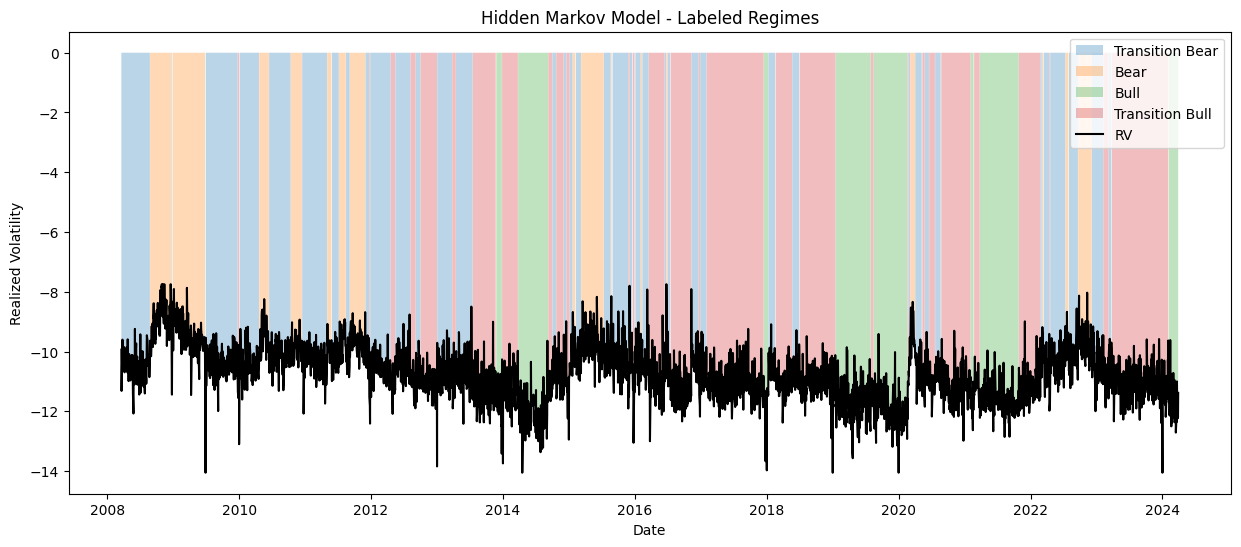

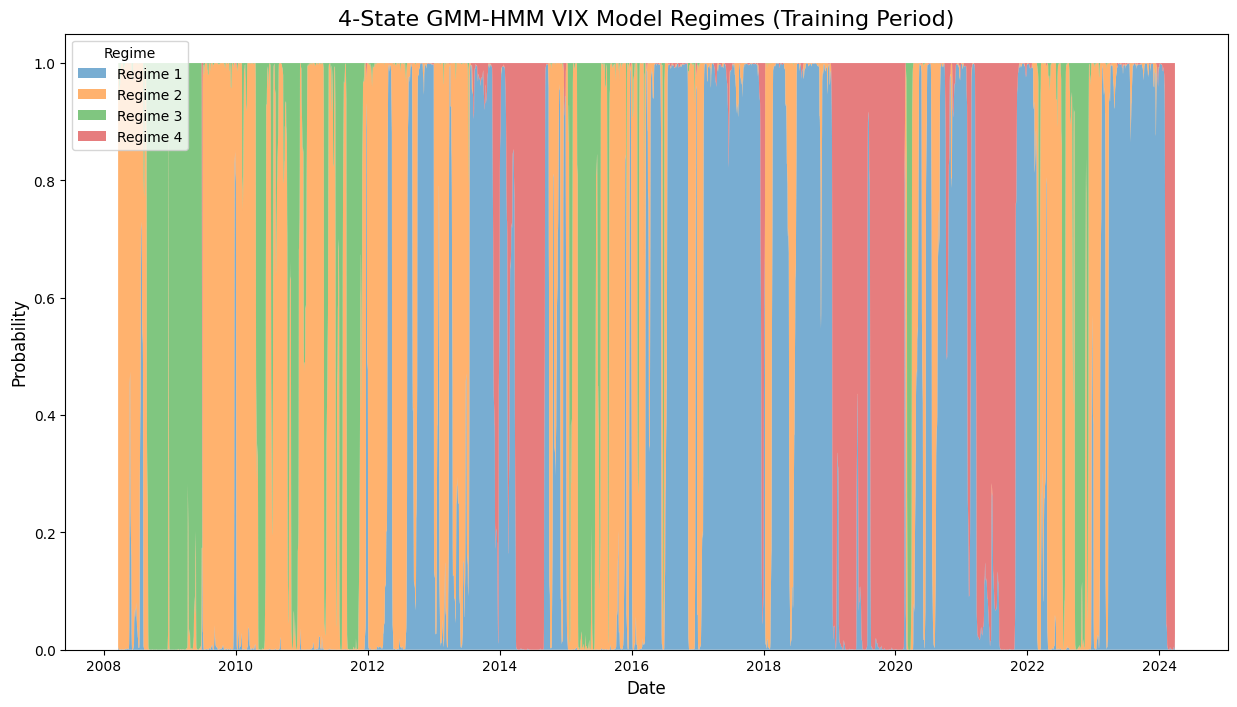

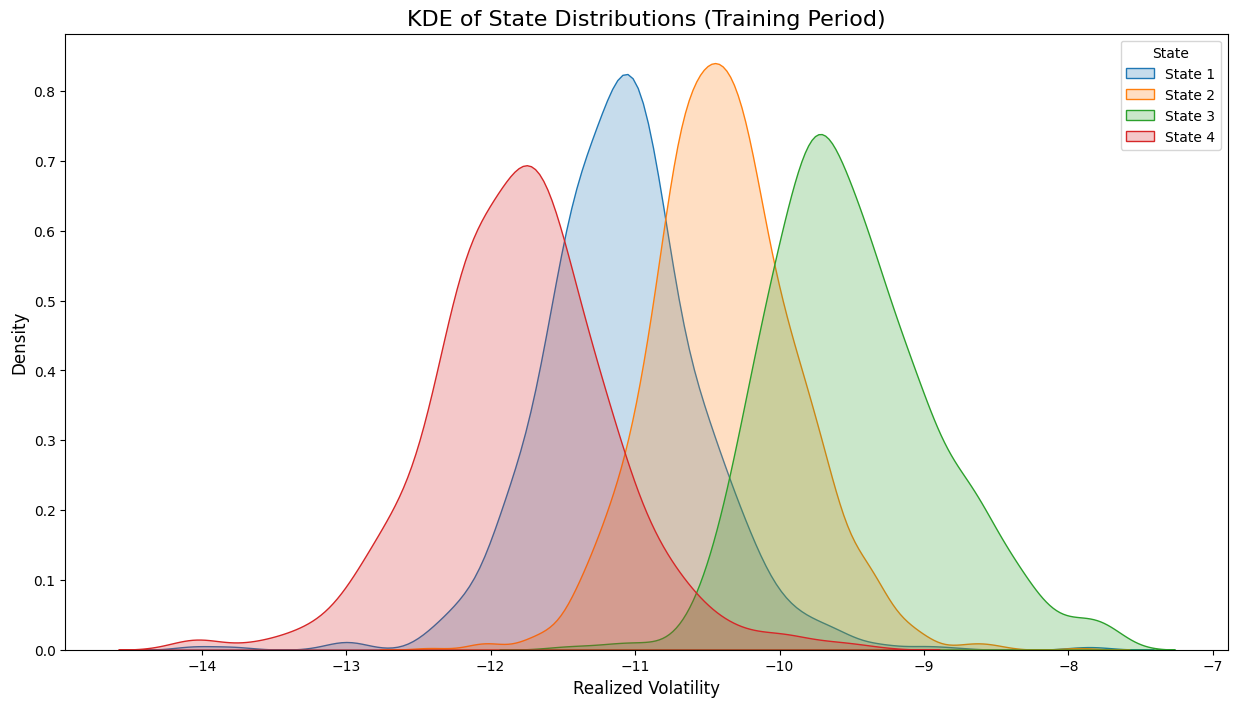

In [51]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GMMHMM
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set a random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Function to fit GMM-HMM to daily RV data
def fit_gmm_hmm(data, n_components=4, n_mix=2, random_state=RANDOM_SEED):
    model = GMMHMM(n_components=n_components, n_mix=n_mix, covariance_type="full", n_iter=1000, random_state=random_state)
    model.fit(data.reshape(-1, 1))
    return model

# Function to generate hidden states and emission probabilities
def generate_hmm_features(hmm_model, data):
    hidden_states = hmm_model.predict(data.reshape(-1, 1))
    emission_probs = hmm_model.predict_proba(data.reshape(-1, 1))
    return hidden_states, emission_probs

# Function to calculate the product of mean and variance for each state
def calculate_state_measures(hmm_model):
    state_measures = []
    for state in range(hmm_model.n_components):
        means = hmm_model.means_[state].flatten()
        covars = np.diagonal(hmm_model.covars_[state], axis1=1, axis2=2).flatten()
        product = means * covars  # Product of mean and variance
        product_mean = np.mean(product)  # Take the mean of the product
        state_measures.append((state, product_mean))
    state_measures.sort(key=lambda x: x[1], reverse=True)
    return state_measures

# Function to label the states based on sorted measures
def label_states(state_measures):
    labels = ['Bear', 'Transition Bear', 'Transition Bull', 'Bull']
    state_labels = {state: label for (state, _), label in zip(state_measures, labels)}
    return state_labels


# Assuming 'train_rv' and 'val_rv' are your time series data
# Scale the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_rv.values.reshape(-1, 1))
val_scaled = scaler.transform(val_rv.values.reshape(-1, 1))

# Fit GMM-HMM on the training data
gmm_hmm_model = fit_gmm_hmm(train_scaled)

# Predict hidden states and emission probabilities for the training data
hidden_states_train, emission_probs_train = generate_hmm_features(gmm_hmm_model, train_scaled)

# Calculate the state measures and label the states
state_measures = calculate_state_measures(gmm_hmm_model)
state_labels = label_states(state_measures)

# Map the labels to the hidden states
labeled_states_train = pd.Series(hidden_states_train).map(state_labels)

# Plot the identified regimes with labels
def plot_labeled_regimes(data, labeled_states, title='Hidden Markov Model - Labeled Regimes'):
    plt.figure(figsize=(15, 6))
    unique_labels = labeled_states.unique()
    for label in unique_labels:
        plt.fill_between(data.index, data.values.flatten(), where=(labeled_states == label), alpha=0.3, label=label)
    plt.plot(data.index, data.values, label='RV', color='k')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Realized Volatility')
    plt.legend()
    plt.show()

# Plot the identified regimes with labeled states
plot_labeled_regimes(train_rv, labeled_states_train)

# Convert the emission probabilities to a DataFrame
emission_probs_df = pd.DataFrame(emission_probs_train, index=train_rv.index, columns=[f'Regime {i+1}' for i in range(emission_probs_train.shape[1])])

# Plot the long-term predicted probabilities of each state
plot_emission_probabilities(emission_probs_df, title='4-State GMM-HMM VIX Model Regimes (Training Period)')

# Plot the KDE of each state
plot_state_kde(hidden_states_train, train_rv.values, title='KDE of State Distributions (Training Period)')


In [57]:
results_df['State_Label']

0      Transition Bull
1      Transition Bull
2      Transition Bull
3      Transition Bull
4      Transition Bull
            ...       
711    Transition Bull
712    Transition Bull
713    Transition Bull
714    Transition Bull
715    Transition Bull
Name: State_Label, Length: 716, dtype: object

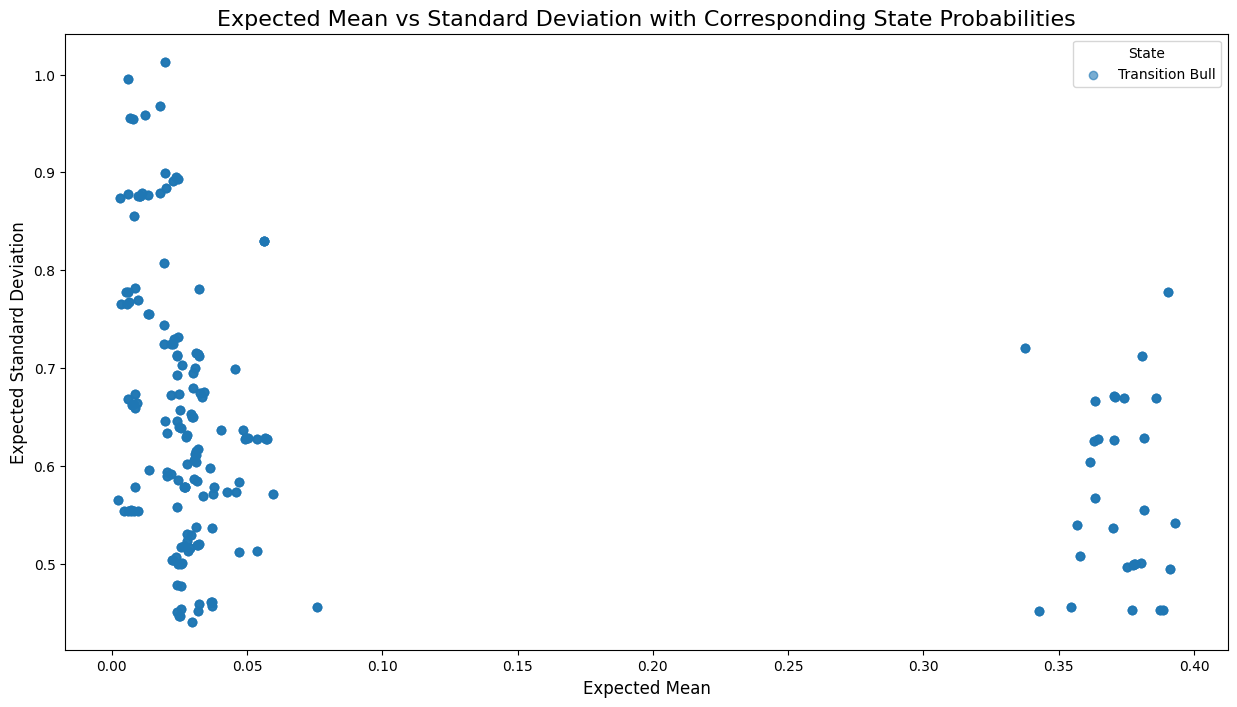

In [56]:
# Flatten the DataFrame for plotting
results_df = results_df.explode('State_Probs').reset_index(drop=True)
results_df['State_Prob'] = results_df['State_Probs'].apply(lambda x: x)
results_df['State_Label'] = results_df.apply(lambda row: state_labels[row['State_Probs'].argmax()], axis=1)

# Plot the expected mean vs. standard deviation
def plot_mean_vs_std(results_df):
    plt.figure(figsize=(15, 8))
    
    for label, df in results_df.groupby('State_Label'):
        plt.scatter(df['Expected_Mean'], df['Expected_STD'], label=label, alpha=0.6)
    
    plt.title('Expected Mean vs Standard Deviation with Corresponding State Probabilities', fontsize=16)
    plt.xlabel('Expected Mean', fontsize=12)
    plt.ylabel('Expected Standard Deviation', fontsize=12)
    plt.legend(title='State')
    plt.show()

plot_mean_vs_std(results_df)

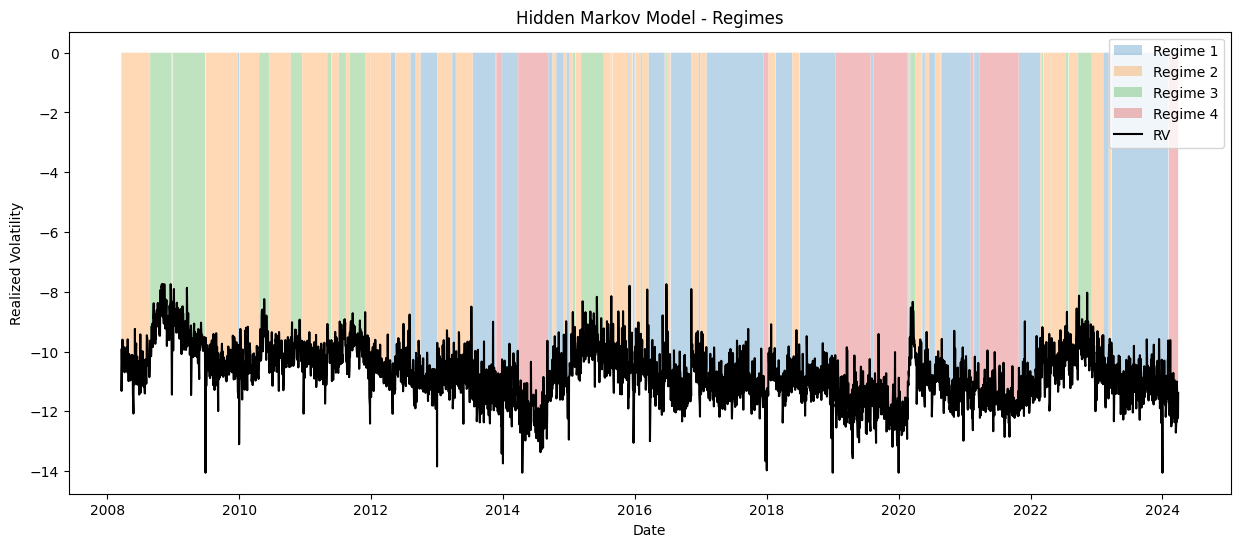

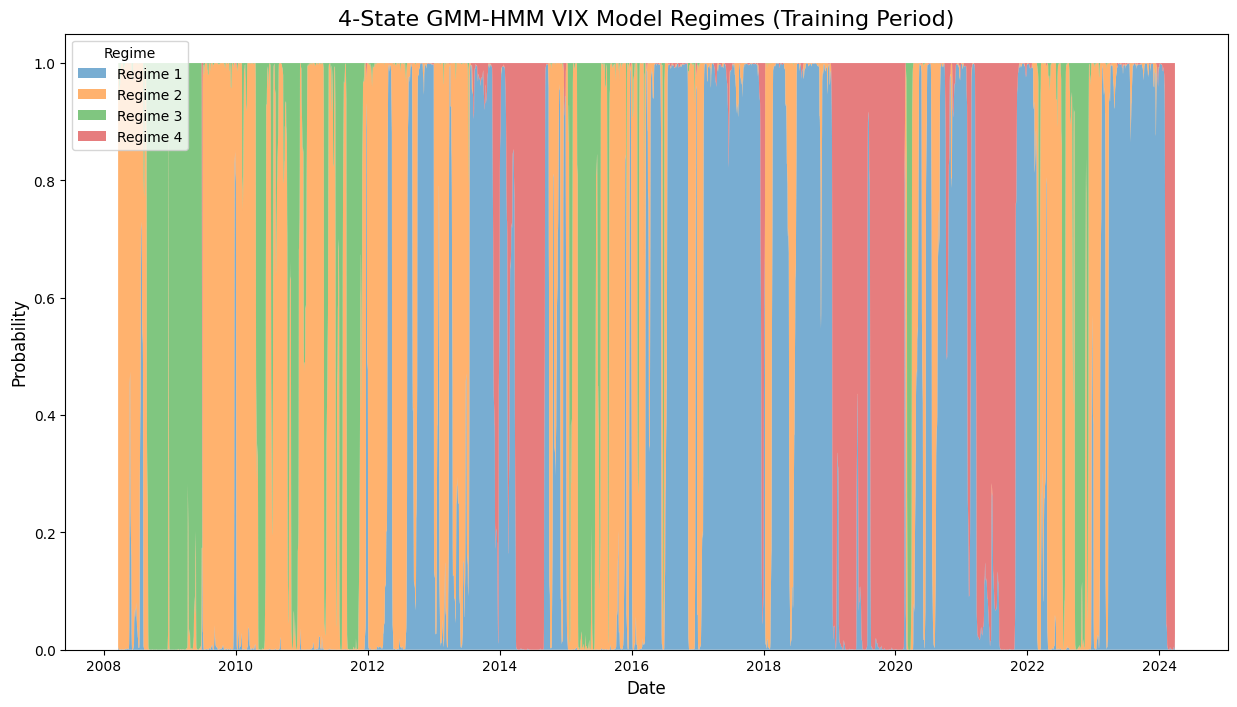

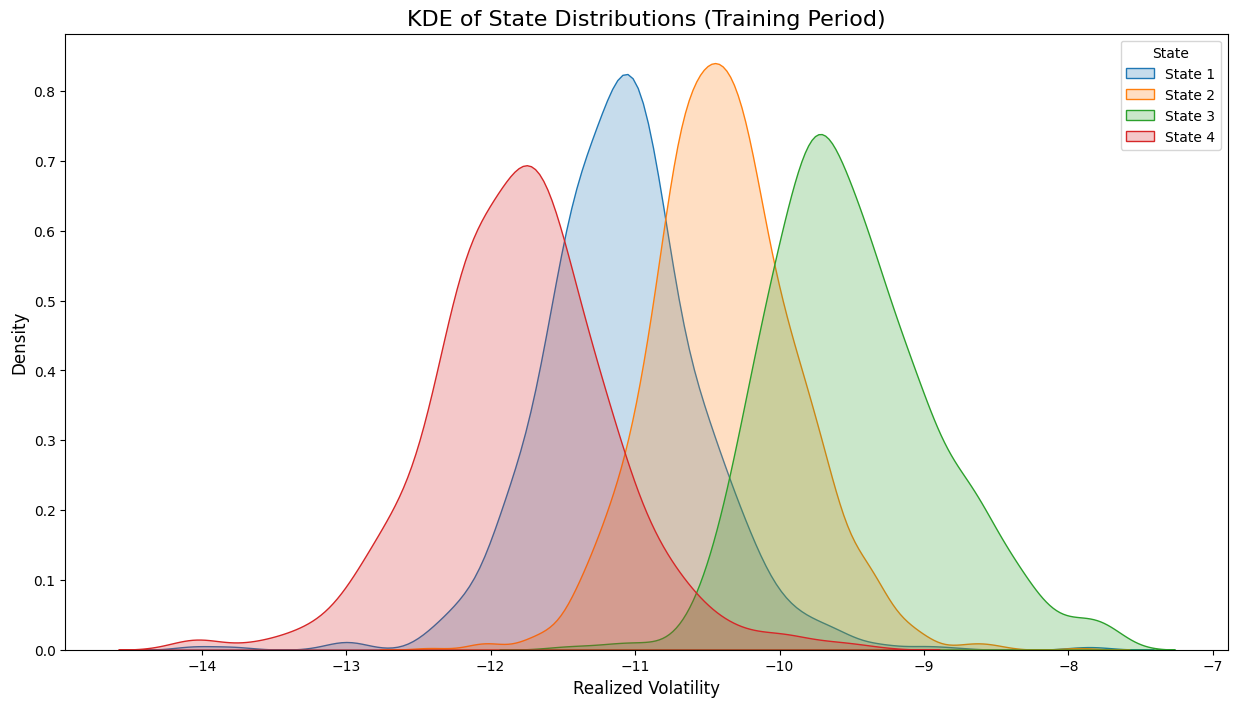

In [49]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GMMHMM
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set a random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Function to fit GMM-HMM to daily RV data
def fit_gmm_hmm(data, n_components=4, n_mix=2, random_state=RANDOM_SEED):
    model = GMMHMM(n_components=n_components, n_mix=n_mix, covariance_type="full", n_iter=1000, random_state=random_state)
    model.fit(data.reshape(-1, 1))
    return model

# Function to generate hidden states and emission probabilities
def generate_hmm_features(hmm_model, data):
    hidden_states = hmm_model.predict(data.reshape(-1, 1))
    emission_probs = hmm_model.predict_proba(data.reshape(-1, 1))
    return hidden_states, emission_probs

# Function to plot the identified regimes
def plot_regimes(data, hidden_states, title='Hidden Markov Model - Regimes'):
    plt.figure(figsize=(15, 6))
    for i in range(hidden_states.max() + 1):
        plt.fill_between(data.index, data.values.flatten(), where=(hidden_states == i), alpha=0.3, label=f'Regime {i+1}')
    plt.plot(data.index, data.values, label='RV', color='k')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Realized Volatility')
    plt.legend()
    plt.show()

# Function to plot the long-term predicted probabilities of each state
def plot_emission_probabilities(emission_probs_df, title='Long-Term Predicted Probabilities of the 4 GMM-HMM States'):
    fig, ax = plt.subplots(figsize=(15, 8))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each regime
    ax.stackplot(emission_probs_df.index, emission_probs_df.T, labels=emission_probs_df.columns, colors=colors, alpha=0.6)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Probability', fontsize=12)
    ax.legend(loc='upper left', title='Regime')
    plt.show()

# Function to plot the KDE of each state
def plot_state_kde(hidden_states, data, title='KDE of State Distributions'):
    unique_states = np.unique(hidden_states)
    plt.figure(figsize=(15, 8))
    
    for state in unique_states:
        state_data = data[hidden_states == state]
        sns.kdeplot(state_data.flatten(), label=f'State {state+1}', fill=True)
    
    plt.title(title, fontsize=16)
    plt.xlabel('Realized Volatility', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend(title='State')
    plt.show()

# Assuming 'train_rv' and 'val_rv' are your time series data
# Scale the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_rv.values.reshape(-1, 1))
val_scaled = scaler.transform(val_rv.values.reshape(-1, 1))

# Fit GMM-HMM on the training data
gmm_hmm_model = fit_gmm_hmm(train_scaled)

# Predict hidden states and emission probabilities for the training data
hidden_states_train, emission_probs_train = generate_hmm_features(gmm_hmm_model, train_scaled)

# Plot the identified regimes
plot_regimes(train_rv, hidden_states_train)

# Convert the emission probabilities to a DataFrame
emission_probs_df = pd.DataFrame(emission_probs_train, index=train_rv.index, columns=[f'Regime {i+1}' for i in range(emission_probs_train.shape[1])])

# Plot the long-term predicted probabilities of each state
plot_emission_probabilities(emission_probs_df, title='4-State GMM-HMM VIX Model Regimes (Training Period)')

# Plot the KDE of each state
plot_state_kde(hidden_states_train, train_rv.values, title='KDE of State Distributions (Training Period)')


In [42]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


In [43]:
# Prepare LSTM input data with HMM features
def prepare_lstm_data(rv_data, hidden_states, emission_probs, look_back=10):
    X, y = [], []
    for i in range(look_back, len(rv_data)):
        features = np.hstack((
            rv_data[i-look_back:i],
            hidden_states[i-look_back:i].reshape(-1, 1),
            emission_probs[i-look_back:i]
        ))
        X.append(features)
        y.append(rv_data[i])
    return np.array(X), np.array(y)

# Prepare LSTM data for training and validation
look_back = 10
X_train, y_train = prepare_lstm_data(train_scaled, hidden_states_train, emission_probs_train, look_back)



# Fit HMM on the training data
hmm_model = fit_hmm(train_scaled)

# Predict hidden states and emission probabilities for the training data
hidden_states_train, emission_probs_train = generate_hmm_features(hmm_model, train_scaled)
# Predict hidden states and emission probabilities for the validation data
hidden_states_val, emission_probs_val = generate_hmm_features(hmm_model, val_scaled)


X_val, y_val = prepare_lstm_data(val_scaled, hidden_states_val, emission_probs_val, look_back)

# Define LSTM model
def create_lstm_model(input_shape, units=30, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=input_shape))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Create the LSTM model
lstm_model = create_lstm_model((look_back, X_train.shape[2]))

# Train the LSTM model
history = lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Predict on the validation set
val_predictions = lstm_model.predict(X_val)

# Inverse scale predictions
val_predictions = scaler.inverse_transform(val_predictions)

# Calculate the Mean Squared Error
mse = mean_squared_error(scaler.inverse_transform(y_val), val_predictions)
print(f"Validation MSE: {mse}")

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.7336 - val_loss: 0.4095
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4089 - val_loss: 0.3983
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3975 - val_loss: 0.3929
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3905 - val_loss: 0.3894
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3854 - val_loss: 0.3869
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3811 - val_loss: 0.3849
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3773 - val_loss: 0.3831
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3738 - val_loss: 0.3815
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3705 - val_loss: 0.3800
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3674 - val_loss: 0.3786
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3645 - val_loss: 0.3772
Epoch 12/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3619 - val_lo

Starting fold 1 with train data from 2008-03-20 to 2012-03-23 (1047 data points) and val data from 2012-03-26 to 2016-03-25 (1044 data points)
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 1 MSE: 0.73221
Fold 1 QLIKE: 0.00312


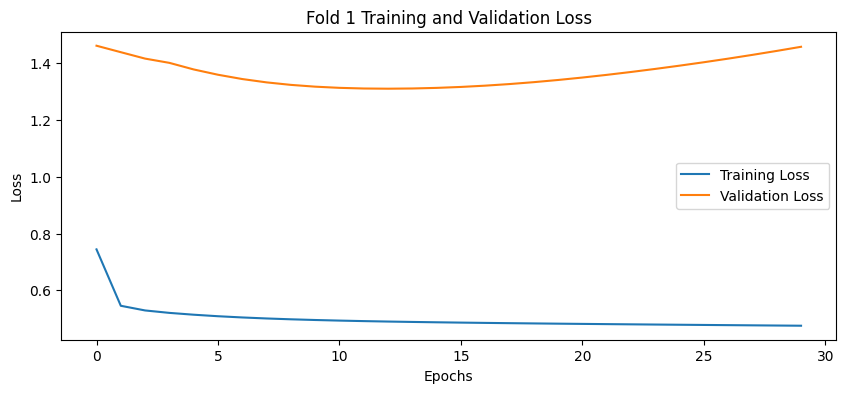

Starting fold 2 with train data from 2008-03-20 to 2016-03-25 (2091 data points) and val data from 2016-03-28 to 2020-03-26 (1044 data points)
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 2 MSE: 0.36197
Fold 2 QLIKE: 0.00147


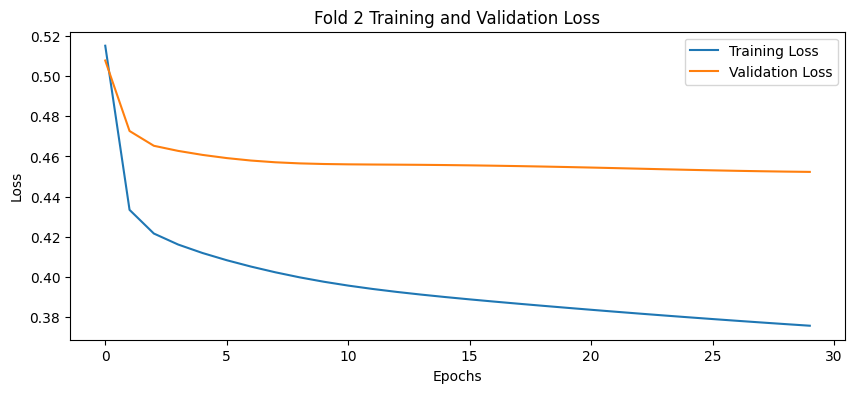

Starting fold 3 with train data from 2008-03-20 to 2020-03-26 (3135 data points) and val data from 2020-03-27 to 2024-03-28 (1044 data points)
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 3 MSE: 0.29655
Fold 3 QLIKE: 0.00126


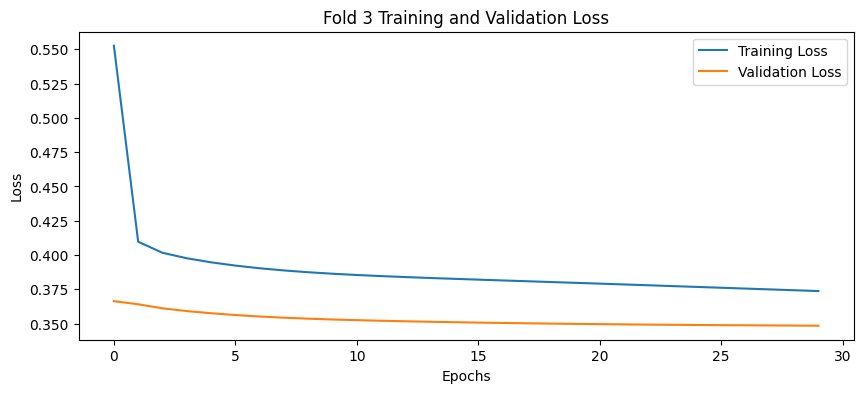

Average MSE: 0.46357
Average qlike: 0.00195


In [44]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# Set a random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Fit HMM to daily RV data
def fit_hmm(data, n_components=3, random_state=RANDOM_SEED):
    model = GaussianHMM(n_components=n_components, covariance_type="full", n_iter=1000, random_state=random_state)
    model.fit(data.reshape(-1, 1))
    return model

# Predict the hidden states and emission probabilities
def generate_hmm_features(hmm_model, data):
    hidden_states = hmm_model.predict(data.reshape(-1, 1))
    emission_probs = hmm_model.predict_proba(data.reshape(-1, 1))
    return hidden_states, emission_probs

# Prepare LSTM input data with HMM features
def prepare_lstm_data(rv_data, hidden_states, emission_probs, look_back=10):
    X, y = [], []
    for i in range(look_back, len(rv_data)):
        features = np.hstack((
            rv_data[i-look_back:i],
            hidden_states[i-look_back:i].reshape(-1, 1),
            emission_probs[i-look_back:i]
        ))
        X.append(features)
        y.append(rv_data[i])
    return np.array(X), np.array(y)

# Define LSTM model
def create_lstm_model(input_shape, units=30, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=input_shape))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Assuming 'RV' is your time series data
RV_df = RV.to_frame(name='RV_daily')  # Convert the RV Series into a DataFrame
RV_df.index = pd.to_datetime(RV_df.index)
RV_df.dropna(inplace=True)

train_rv = RV_df['RV_daily']

# Time series cross-validator
tscv = TimeSeriesSplit(n_splits=3)

mse_vals = []
qlike_vals = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(train_rv)):
    # Extracting dates and number of data points
    train_start_date = train_rv.index[train_idx[0]].date()
    train_end_date = train_rv.index[train_idx[-1]].date()
    train_data_points = len(train_idx)
    
    val_start_date = train_rv.index[val_idx[0]].date()
    val_end_date = train_rv.index[val_idx[-1]].date()
    val_data_points = len(val_idx)
    
    print(f"Starting fold {fold+1} with train data from {train_start_date} to {train_end_date} ({train_data_points} data points) and val data from {val_start_date} to {val_end_date} ({val_data_points} data points)")
    
    # Splitting data into training and validation sets using the indices
    fold_train_data, fold_val_data = train_rv.iloc[train_idx], train_rv.iloc[val_idx]
    
    # Scale the data
    scaler = StandardScaler()
    fold_train_scaled = scaler.fit_transform(fold_train_data.values.reshape(-1, 1))
    fold_val_scaled = scaler.transform(fold_val_data.values.reshape(-1, 1))
    
    # Fit HMM on the training data
    hmm_model = fit_hmm(fold_train_scaled)
    
    # Generate HMM features for training and validation data
    hidden_states_train, emission_probs_train = generate_hmm_features(hmm_model, fold_train_scaled)
    hidden_states_val, emission_probs_val = generate_hmm_features(hmm_model, fold_val_scaled)
    
    # Prepare data for LSTM
    look_back = 10
    fold_X_train, fold_y_train = prepare_lstm_data(fold_train_scaled, hidden_states_train, emission_probs_train, look_back)
    fold_X_val, fold_y_val = prepare_lstm_data(fold_val_scaled, hidden_states_val, emission_probs_val, look_back)
    
    # Create the LSTM model
    fold_lstm_model = create_lstm_model((look_back, fold_X_train.shape[2]))
    fold_history = fold_lstm_model.fit(fold_X_train, fold_y_train, epochs=30, batch_size=32, validation_data=(fold_X_val, fold_y_val), verbose=0)
    
    # Predict on the validation set
    predictions = fold_lstm_model.predict(fold_X_val)

    # Inverse Transform the prediction and actual 
    fold_y_true = scaler.inverse_transform(fold_y_val)
    fold_y_pred = scaler.inverse_transform(predictions)

    # Calculate the Mean Squared Error
    mse = mean_squared_error(fold_y_true, fold_y_pred)
    mse_vals.append(mse)

    # Calculate the QLIKE
    qlike = q_like(fold_y_true, fold_y_pred)
    qlike_vals.append(qlike)
    
    # Output Fold Results
    print(f"Fold {fold+1} MSE: {round(mse,5)}")
    print(f"Fold {fold+1} QLIKE: {round(qlike,5)}")

    # Plot training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(fold_history.history['loss'], label='Training Loss')
    plt.plot(fold_history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold+1} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

avg_mse = np.mean(mse_vals)
avg_qlike = np.mean(qlike_vals)

print(f"Average MSE: {round(avg_mse,5)}")
print(f"Average qlike: {round(avg_qlike,5)}")


Trial 60 Complete [00h 00m 02s]
val_loss: 0.3567681312561035

Best val_loss So Far: 0.34811827540397644
Total elapsed time: 00h 01m 46s
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5479
Epoch 2/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4421
Epoch 3/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4345
Epoch 4/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4296
Epoch 5/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4255
Epoch 6/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4220
Epoch 7/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4191
Epoch 8/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4167
Epoch 9/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4146
Epoch 10/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4130
Epoch 11/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4119
Epoch 12/30
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4109
Epoch 13/30
131/13

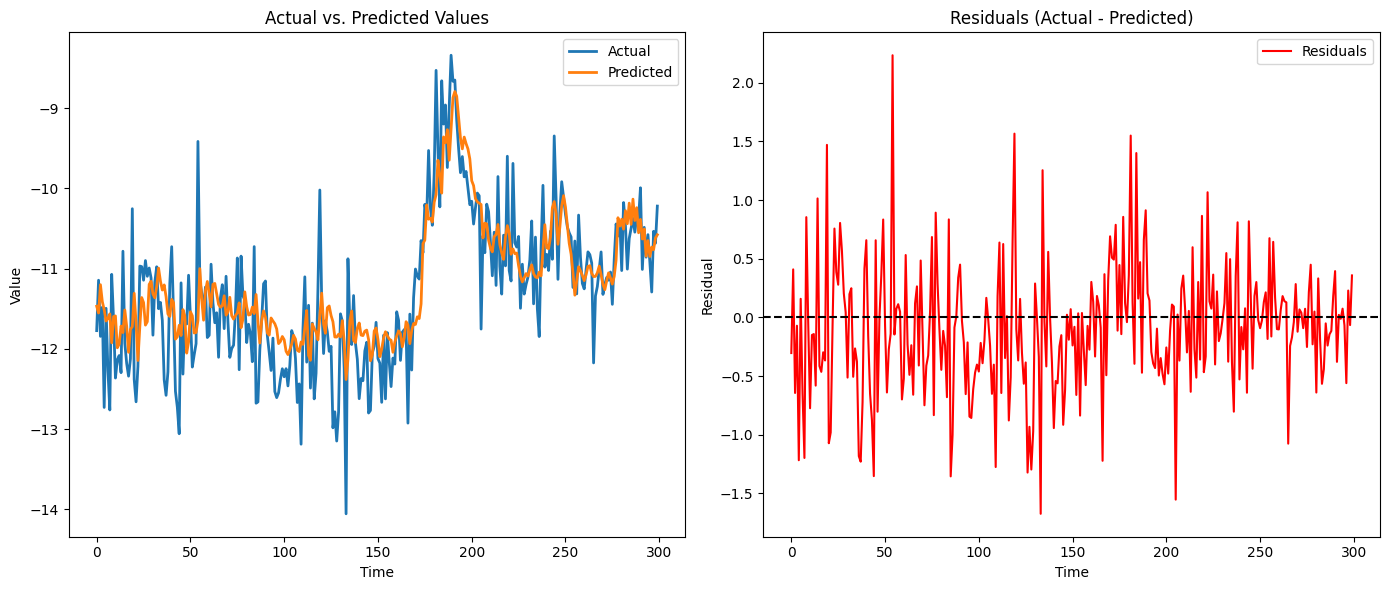

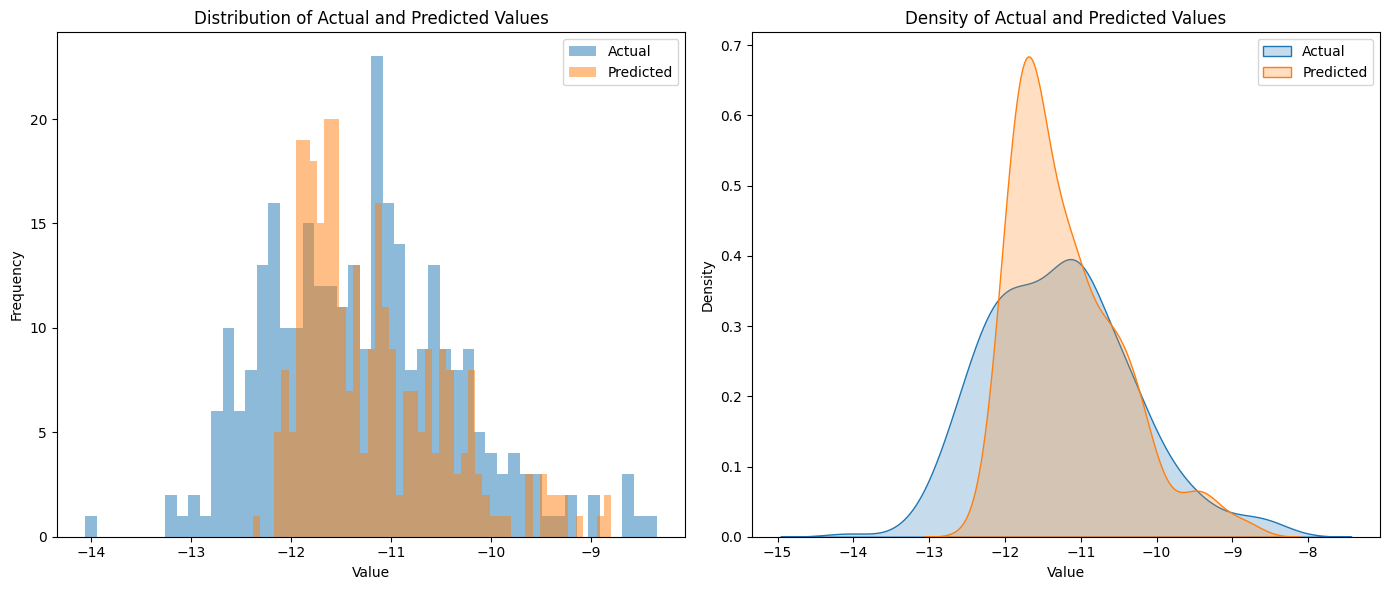

,Model,Val MSE,Val QLike
0,Tuned LSTM,0.289395,0.001148


In [45]:
import os
import shutil
from collections import defaultdict
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from keras_tuner import HyperModel, Hyperband
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        units = hp.Int('units', min_value=50, max_value=200, step=50)
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        model = create_lstm_model(
            input_shape=self.input_shape, 
            units=units, 
            learning_rate=learning_rate
        )
        return model

def create_lstm_model(input_shape, units=30, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=input_shape))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def scale_data(train_data, val_data):
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train_data.values.reshape(-1, 1))
    val_scaled = scaler.transform(val_data.values.reshape(-1, 1))
    return train_scaled, val_scaled, scaler

def q_like(true, pred):
    return -np.mean(np.log(pred / true) - (pred - true) / true)

# Prepare LSTM input data with HMM features
def prepare_lstm_data(rv_data, hidden_states, emission_probs, look_back=10):
    X, y = [], []
    for i in range(look_back, len(rv_data)):
        features = np.hstack((
            rv_data[i-look_back:i],
            hidden_states[i-look_back:i].reshape(-1, 1),
            emission_probs[i-look_back:i]
        ))
        X.append(features)
        y.append(rv_data[i])
    return np.array(X), np.array(y)


# Time series cross-validator
tscv = TimeSeriesSplit(n_splits=3)
look_back = 10
n_hmm_components = 3  # Number of HMM components
input_shape = (look_back, 1 + 1 + n_hmm_components)  # RV + hidden states + emission probs

hyper_lstm_model = LSTMHyperModel(input_shape=input_shape)

# Initialize variables for performance tracking
performance_summary = defaultdict(lambda: {'sum': 0, 'count': 0})

for fold, (train_idx, val_idx) in enumerate(tscv.split(train_rv)):
    print(f"Starting fold {fold+1}")
    
    # Data preprocessing
    fold_train_data, fold_val_data = train_rv.iloc[train_idx], train_rv.iloc[val_idx]
    train_scaled, val_scaled, fold_scaler = scale_data(fold_train_data, fold_val_data)
    
    # Fit HMM on the training data
    hmm_model = fit_hmm(train_scaled)
    
    # Generate HMM features for training and validation data
    hidden_states_train, emission_probs_train = generate_hmm_features(hmm_model, train_scaled)
    hidden_states_val, emission_probs_val = generate_hmm_features(hmm_model, val_scaled)
    
    # Prepare LSTM input data
    fold_X_train, fold_y_train = prepare_lstm_data(train_scaled, hidden_states_train, emission_probs_train, look_back)
    fold_X_val, fold_y_val = prepare_lstm_data(val_scaled, hidden_states_val, emission_probs_val, look_back)
    
    # Clear previous tuning session data
    tuner_directory = f'lstm_tuning_fold_{fold+1}'
    project_name = 'time_series_prediction'
    project_dir = os.path.join(tuner_directory, project_name)
    if os.path.exists(project_dir):
        shutil.rmtree(project_dir)
        print(f"Cleared previous tuning session at: {project_dir}")

    # Hyperband Tuner setup
    tuner = Hyperband(
        hypermodel=hyper_lstm_model,
        objective='val_loss',
        max_epochs=10,  # Adjust based on your dataset and available compute resources
        factor=3,  # Default value, adjust if needed
        hyperband_iterations=2,  # Number of times to run Hyperband, picking the best overall model
        directory=tuner_directory,
        project_name=project_name
    )
    
    tuner.search(fold_X_train, fold_y_train, epochs=10, validation_data=(fold_X_val, fold_y_val))
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Get best model and make predictions
    best_model = tuner.get_best_models(num_models=1)[0]
    predictions = best_model.predict(fold_X_val)
    
    # Inverse scale predictions
    fold_y_true = fold_scaler.inverse_transform(fold_y_val.reshape(-1, 1))
    fold_y_pred = fold_scaler.inverse_transform(predictions)
    
    q_like_score = q_like(fold_y_true, fold_y_pred)
    
    # Create a unique identifier for the hyperparameter set
    hyperparams_id = f"{best_hp.get('units')}_{best_hp.get('learning_rate')}"
    
    # Update performance summary
    performance_summary[hyperparams_id]['sum'] += q_like_score
    performance_summary[hyperparams_id]['count'] += 1

# Select the best hyperparameters based on average q_like
best_hyperparams_id, best_metrics = min(performance_summary.items(), key=lambda x: x[1]['sum'] / x[1]['count'])

# Split the identifier back into components
split_params = best_hyperparams_id.split('_')
units = int(split_params[0])
learning_rate = float(split_params[1])

# Final model training on full dataset
train_scaled, val_scaled, scaler = scale_data(train_rv, val_rv)
hmm_model_final = fit_hmm(train_scaled)
hidden_states_train, emission_probs_train = generate_hmm_features(hmm_model_final, train_scaled)
hidden_states_val, emission_probs_val = generate_hmm_features(hmm_model_final, val_scaled)
X_train, y_train = prepare_lstm_data(train_scaled, hidden_states_train, emission_probs_train, look_back)
X_val, y_val = prepare_lstm_data(val_scaled, hidden_states_val, emission_probs_val, look_back)

final_lstm_model = create_lstm_model(input_shape, units=units, learning_rate=learning_rate)
final_lstm_model.fit(X_train, y_train, epochs=30, batch_size=32)  # Adjust epochs and batch_size as needed

# Predict on the validation set
predictions = final_lstm_model.predict(X_val)
fold_y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
predictions_actual = scaler.inverse_transform(predictions).flatten()

N = 300
plot_predictions_and_residuals(fold_y_val_actual[:N], predictions_actual[:N])
val_metrics(fold_y_val_actual, predictions_actual, 'Tuned LSTM')


In [21]:
# no aug

Epoch 1/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5162 - val_loss: 0.4282
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4205 - val_loss: 0.4225
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4162 - val_loss: 0.4206
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4139 - val_loss: 0.4198
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4123 - val_loss: 0.4195
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4111 - val_loss: 0.4193
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4100 - val_loss: 0.4191
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4091 - val_loss: 0.4189
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4083 - val_loss: 0.4187
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4076 - val_loss: 0.4184
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4069 - val_loss: 0.4182
Epoch 12/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4064 - val_lo

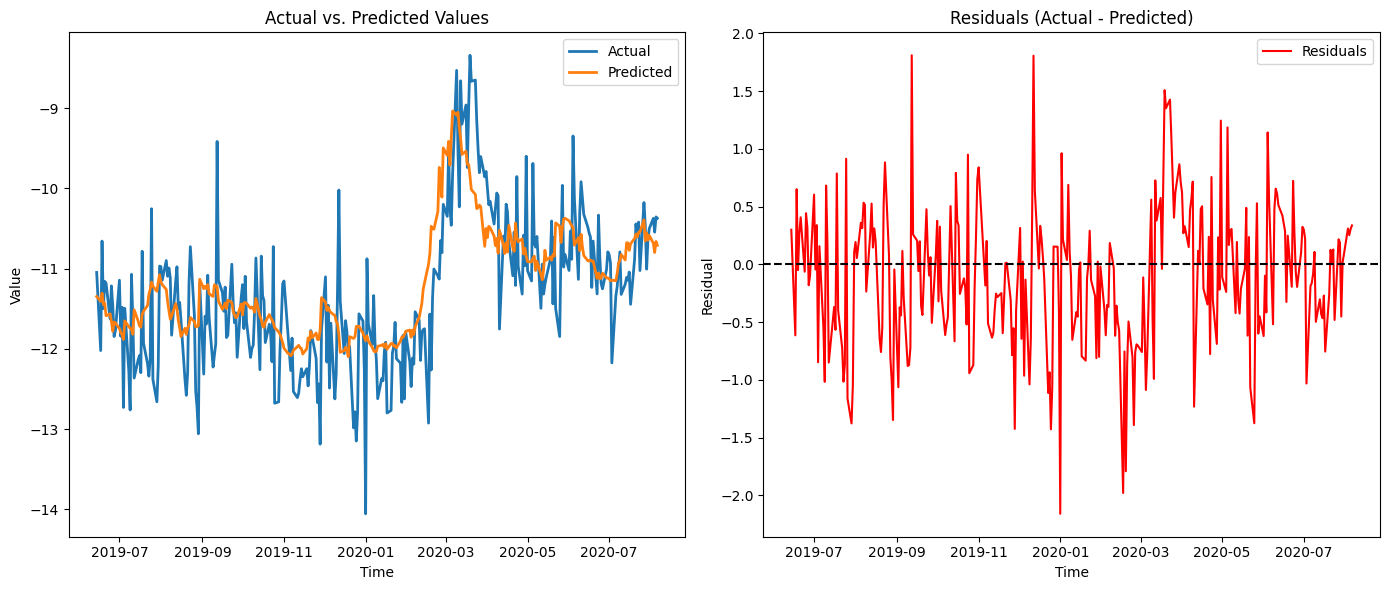

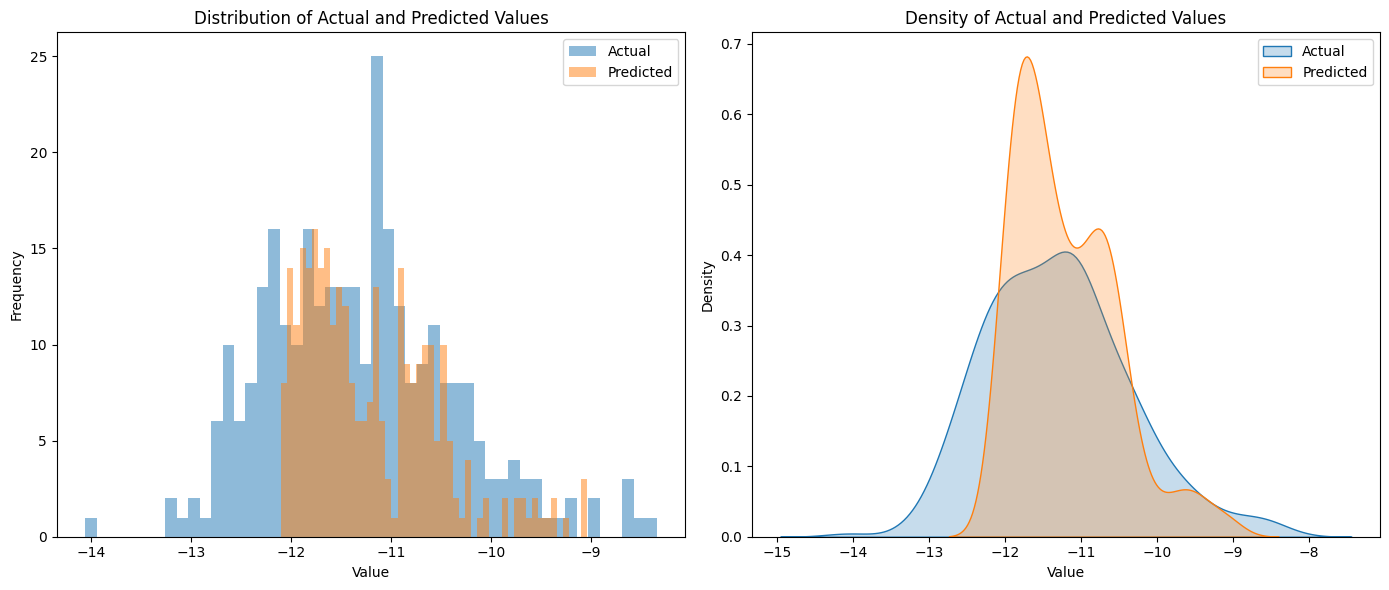

In [19]:
# # Prepare LSTM input data with HMM features
# def prepare_lstm_data(rv_data, look_back=10):
#     X, y = [], []
#     for i in range(look_back, len(rv_data)):
#         features = np.hstack((
#             rv_data[i-look_back:i],
#             # hidden_states[i-look_back:i].reshape(-1, 1),
#             # emission_probs[i-look_back:i]
#         ))
#         X.append(features)
#         y.append(rv_data[i])
#     return np.array(X), np.array(y)

# # Prepare LSTM data for training and validation
# look_back = 10
# X_train, y_train = prepare_lstm_data(train_scaled, look_back)



# X_val, y_val = prepare_lstm_data(val_scaled, look_back)

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# from tensorflow.keras.optimizers import Adam

# # Define LSTM model
# def create_lstm_model(input_shape, units=30, learning_rate=0.001):
#     model = Sequential()
#     model.add(LSTM(units=units, input_shape=input_shape))
#     model.add(Dense(1))
#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(optimizer=optimizer, loss='mean_squared_error')
#     return model

# # Create the LSTM model
# lstm_model = create_lstm_model((look_back, X_train.shape[2]))

# # Train the LSTM model
# history = lstm_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# # Predict on the validation set
# val_predictions = lstm_model.predict(X_val)

# # Inverse scale predictions
# val_predictions = scaler.inverse_transform(val_predictions)

# # Calculate the Mean Squared Error
# mse = mean_squared_error(scaler.inverse_transform(y_val), val_predictions)
# print(f"Validation MSE: {mse}")

# val_predictions = pd.Series(val_predictions.flatten(), index=val_rv.index[:len(val_predictions)])

# # Plot predictions and residuals
# N = 300  # Adjust as needed
# plot_predictions_and_residuals(val_rv[:N], val_predictions[:N])



# 5 Simple LSTM

## 5.1 Train Test Val Split

This function gets the t - 9 up to t points and then the target is the t + 1, example tested on a list from 1 to 100, 

X : [[ 1  2  3  4  5  6  7  8  9 10]]


Y: [11]

In [25]:
def create_dataset(data, look_back=10):
    """
    Create dataset with sequences of lagged values for LSTM model training.

    This function generates features and labels from a time series dataset. Each feature set
    contains `look_back` number of lagged values intended to predict the next value in the sequence.

    Parameters:
    - data (numpy.ndarray): Time series data.
    - look_back (int): Number of lagged values to use as features for predicting the next value.

    Returns:
    - numpy.ndarray: Feature dataset, where each row contains a sequence of `look_back` lagged values.
    - numpy.ndarray: Label dataset, where each value corresponds to the true value following a sequence.
    """
    X, Y = [], []
    for i in range(len(data)-look_back-1):
        a = data[i:(i+look_back)]
        X.append(a)
        Y.append(data[i + look_back])
    return np.array(X), np.array(Y)

def scale_data(train_data, val_data):
    """
    Scale train and validation data using MinMaxScaler.

    This function fits a MinMaxScaler to the training data and then transforms both the training
    and validation datasets according to the fitted scaler. It is designed to normalize the data
    to a specified range, which is essential for the effective training of neural networks.

    Parameters:
    - train_data (pandas.Series or pandas.DataFrame): Training dataset.
    - val_data (pandas.Series or pandas.DataFrame): Validation dataset.

    Returns:
    - numpy.ndarray: Scaled training dataset.
    - numpy.ndarray: Scaled validation dataset.
    - MinMaxScaler: Fitted scaler object for inverse transformation or scaling new data.
    """
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler.fit(train_data.values.reshape(-1, 1))
    train_scaled = scaler.transform(train_data.values.reshape(-1, 1))
    val_scaled = scaler.transform(val_data.values.reshape(-1, 1))
    return train_scaled, val_scaled, scaler


def prepare_data(scaled_train, scaled_val):
    """
    Prepare data for LSTM training from scaled datasets.

    This function takes scaled training and validation datasets and converts them into
    sequences using create_dataset for LSTM model training. It involves reshaping the data into a
    format that LSTM models can work with, which is [samples, time steps, features].

    Parameters:
    - scaled_train (numpy.ndarray): Scaled training data.
    - scaled_val (numpy.ndarray): Scaled validation data.

    Returns:
    - numpy.ndarray: Reshaped training features suitable for LSTM input.
    - numpy.ndarray: Training labels.
    - numpy.ndarray: Reshaped validation features suitable for LSTM input.
    - numpy.ndarray: Validation labels.
    """
    X_train, y_train = create_dataset(scaled_train)
    X_val, y_val = create_dataset(scaled_val)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    return X_train, y_train, X_val, y_val

## 5.2 Model Architecture

First define a model that can vary based on hyperparameters, create a function that constructs an LSTM model, the model's number of units, activation function, and learning rate are parameters that can be adjusted 

In [16]:
def create_lstm_1_model(input_shape, units = 30, learning_rate=0.001):
    """
    Creates an LSTM model with customizable hyperparameters.
    
    Parameters:
    - input_shape: Tuple specifying the shape of the input data.
    - units: Integer, the number of units in the LSTM layer.
    - activation: String, the activation function to use in the LSTM layer.
    - learning_rate: Float, the learning rate for the Adam optimizer.
    
    Returns:
    - A compiled Keras model.
    """
    model = Sequential()
    model.add(LSTM(units=units, input_shape=input_shape))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


look_back = 10
batch_size = 32
epochs = 30

## 5.3 Cross Validation

Starting fold 1 with train data from 2008-04-17 to 2011-02-01 (729 data points) and val data from 2011-02-02 to 2013-11-14 (727 data points)
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 1 MSE: 0.30118
Fold 1 QLIKE: 0.00134


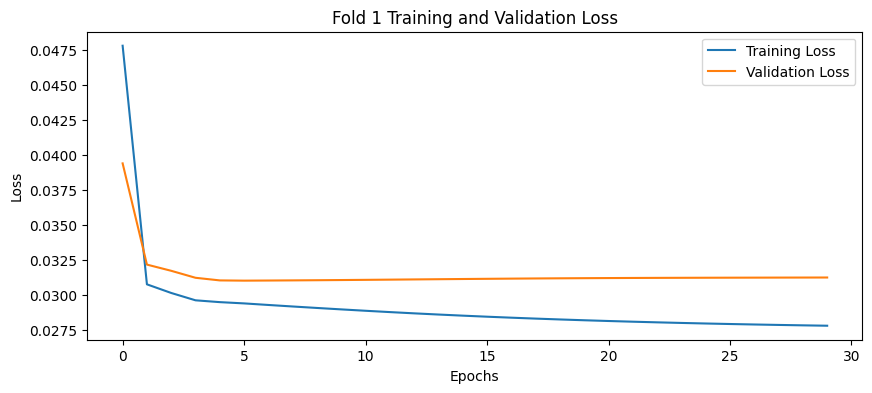

Starting fold 2 with train data from 2008-04-17 to 2013-11-14 (1456 data points) and val data from 2013-11-15 to 2016-08-30 (727 data points)
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Fold 2 MSE: 0.46642
Fold 2 QLIKE: 0.00204


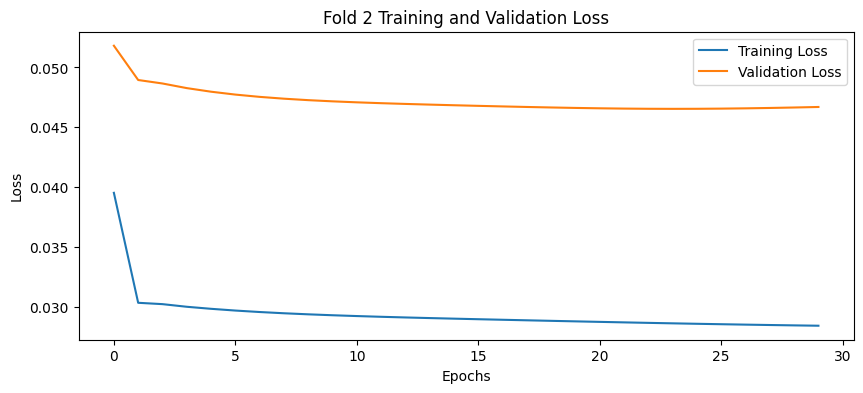

Starting fold 3 with train data from 2008-04-17 to 2016-08-30 (2183 data points) and val data from 2016-08-31 to 2019-06-13 (727 data points)
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 3 MSE: 0.36302
Fold 3 QLIKE: 0.00149


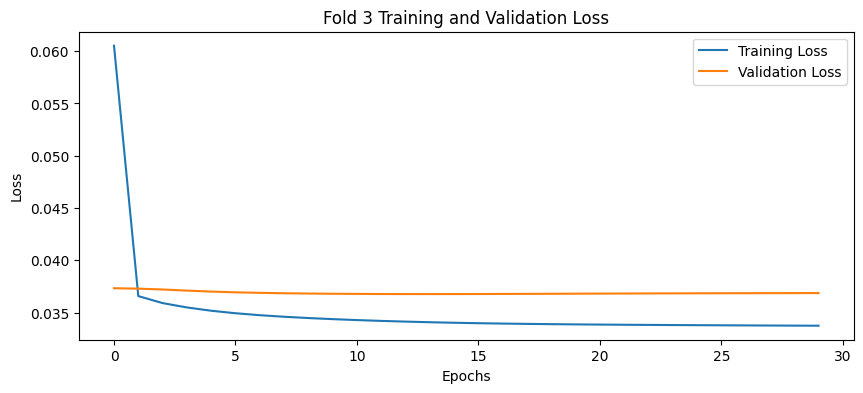

Average MSE: 0.37688
Average qlike: 0.00162


In [17]:
# Time series cross-validator
tscv = TimeSeriesSplit(n_splits=3)

# fold_scores = []
mse_vals = []
qlike_vals = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(train_rv)):
    # Extracting dates and number of data points
    train_start_date = train_rv.index[train_idx[0]].date()
    train_end_date = train_rv.index[train_idx[-1]].date()
    train_data_points = len(train_idx)
    
    val_start_date = train_rv.index[val_idx[0]].date()
    val_end_date = train_rv.index[val_idx[-1]].date()
    val_data_points = len(val_idx)
    
    print(f"Starting fold {fold+1} with train data from {train_start_date} to {train_end_date} ({train_data_points} data points) and val data from {val_start_date} to {val_end_date} ({val_data_points} data points)")
    
    # Splitting data into training and validation sets using the indices
    fold_train_data, fold_val_data = train_rv.iloc[train_idx], train_rv.iloc[val_idx]
    
    # Use the scale_data function to scale the data
    fold_train_scaled, fold_val_scaled, scaler = scale_data(fold_train_data, fold_val_data)
    
    # Prepare data for LSTM using the prepare_data function
    fold_X_train, fold_y_train, fold_X_val, fold_y_val = prepare_data(fold_train_scaled, fold_val_scaled)
    
    # Create the LSTM model
    fold_lstm_model = create_lstm_1_model((fold_X_train.shape[1], 1))
    fold_history = fold_lstm_model.fit(fold_X_train, fold_y_train, epochs= epochs, batch_size= batch_size, verbose=0, validation_data=(fold_X_val, fold_y_val))
    
    # Predict on the validation set
    predictions = fold_lstm_model.predict(fold_X_val)

    # Inverse Transform the prediction and actual 
    fold_y_true = scaler.inverse_transform(fold_y_val)
    fold_y_pred = scaler.inverse_transform(predictions)

    # Calculate the Mean Squared Error
    mse = mean_squared_error(fold_y_true, fold_y_pred)
    mse_vals.append(mse)

    # Calculate the QLIKE
    qlike = q_like(fold_y_true, fold_y_pred)
    qlike_vals.append(qlike)
    
    # Output Fold Results
    print(f"Fold {fold+1} MSE: {round(mse,5)}")
    print(f"Fold {fold+1} QLIKE: {round(qlike,5)}")

    # Plot training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(fold_history.history['loss'], label='Training Loss')
    plt.plot(fold_history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold+1} Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

avg_mse = np.mean(mse_vals)
avg_qlike = np.mean(qlike_vals)

print(f"Average MSE: {round(avg_mse,5)}")
print(f"Average qlike: {round(avg_qlike,5)}")

## 5.4 Hyper Parameter

### 5.4.1 HyperModel Class

keras requires a hypermodel that specifies how the model should be build, wrap the model creation function above in a class that inhereits from hypermodel 

In [18]:
class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        units = hp.Int('units', min_value=50, max_value=200, step=50)
        # activation = hp.Choice('activation', values=['tanh'])
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        model = create_lstm_1_model(
            input_shape=self.input_shape, 
            units=units, 
            # activation=activation, 
            learning_rate=learning_rate
        )
        return model

### 5.4.2 Hyperparameter tuning with cross-validation

now integrate hyperparameter tuning within the cross-validation loop, for each fold, a new instance of the tuner is created and used to find the best hyperpramaeters for that fold 

In [19]:
tscv = TimeSeriesSplit(n_splits=3)
input_shape = (look_back, 1)  # Adjust based on your dataset
hyper_lstm_model = LSTMHyperModel(input_shape=input_shape)

# This will hold the sum of q_like scores and count for each hyperparameter combination across folds
performance_summary = defaultdict(lambda: {'sum': 0, 'count': 0})

for fold, (train_idx, val_idx) in enumerate(tscv.split(train_rv)):
    print(f"Starting fold {fold+1}")
# Data preprocessing
    fold_train_data, fold_val_data = train_rv.iloc[train_idx], train_rv.iloc[val_idx]
    train_scaled, val_scaled, fold_scaler = scale_data(fold_train_data, fold_val_data)
    fold_X_train, fold_y_train, fold_X_val, fold_y_val = prepare_data(train_scaled, val_scaled)
    
    # Clear previous tuning session data
    tuner_directory = f'lstm_tuning_fold_{fold+1}'
    project_name = 'time_series_prediction'
    project_dir = os.path.join(tuner_directory, project_name)
    if os.path.exists(project_dir):
        shutil.rmtree(project_dir)
        print(f"Cleared previous tuning session at: {project_dir}")

    # With Hyperband initialization:
    tuner = Hyperband(
        hypermodel=hyper_lstm_model,
        objective='val_loss',
        max_epochs=10,  # Adjust based on your dataset and available compute resources
        factor=3,  # Default value, adjust if needed
        hyperband_iterations=2,  # Number of times to run Hyperband, picking the best overall model
        directory=tuner_directory,
        project_name=project_name
    )
    tuner.search(fold_X_train, fold_y_train, epochs=10, validation_data=(fold_X_val, fold_y_val))
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

    # Assuming you have a defined q_like function
    predictions = tuner.get_best_models(num_models=1)[0].predict(fold_X_val)

    # Inverse scale 
    fold_y_true = fold_scaler.inverse_transform(fold_y_val)
    fold_y_pred = fold_scaler.inverse_transform(predictions)

    q_like_score = q_like(fold_y_true, fold_y_pred)

    # Create a unique identifier for the hyperparameter set
    hyperparams_id = f"{best_hp.get('units')}_{best_hp.get('learning_rate')}"

    # Update performance summary
    performance_summary[hyperparams_id]['sum'] += q_like_score
    performance_summary[hyperparams_id]['count'] += 1

# Select the best hyperparameters based on average q_like
best_hyperparams_id, best_metrics = min(performance_summary.items(), key=lambda x: x[1]['sum'] / x[1]['count'])

# Split the identifier back into components
split_params = best_hyperparams_id.split('_')

# Correctly parse each component
units = int(split_params[0])
# activation = split_params[1]  # Keep as string, no conversion needed
learning_rate = float(split_params[1])

# Assuming create_lstm_model is defined and works as expected
final_lstm_1_model = create_lstm_1_model(
    input_shape=input_shape, 
    units=units, 
    # activation=activation, 
    learning_rate=learning_rate
)

print(f"Best Hyperparameters: units={units}, learning_rate={learning_rate}, Average Q-Like: {best_metrics['sum'] / best_metrics['count']}")

Trial 60 Complete [00h 00m 04s]
val_loss: 0.03688684105873108

Best val_loss So Far: 0.036440324038267136
Total elapsed time: 00h 01m 35s
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Best Hyperparameters: units=50, learning_rate=0.0016514956852749707, Average Q-Like: 0.0013365256482366576


### Evaluate Tuned Model On Val Set

Epoch 1/30


91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0492 
Epoch 2/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0378
Epoch 3/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0374
Epoch 4/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0372
Epoch 5/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0371
Epoch 6/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0369
Epoch 7/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0369
Epoch 8/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0368
Epoch 9/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0367
Epoch 10/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0367
Epoch 11/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0367
Epoch 12/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0366
Epoch 13/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0366
Epoch 14/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0366
Epoch 15/30
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0365
Epoch 16/30
91/91 ━━━━━━━━━━━

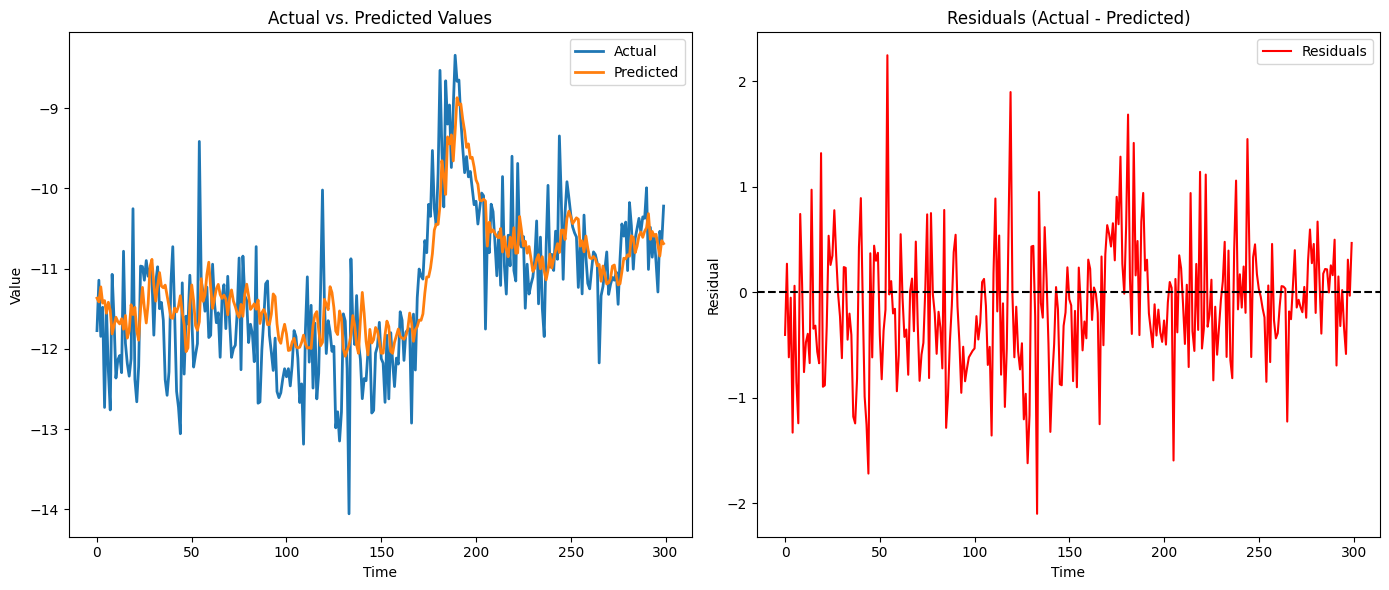

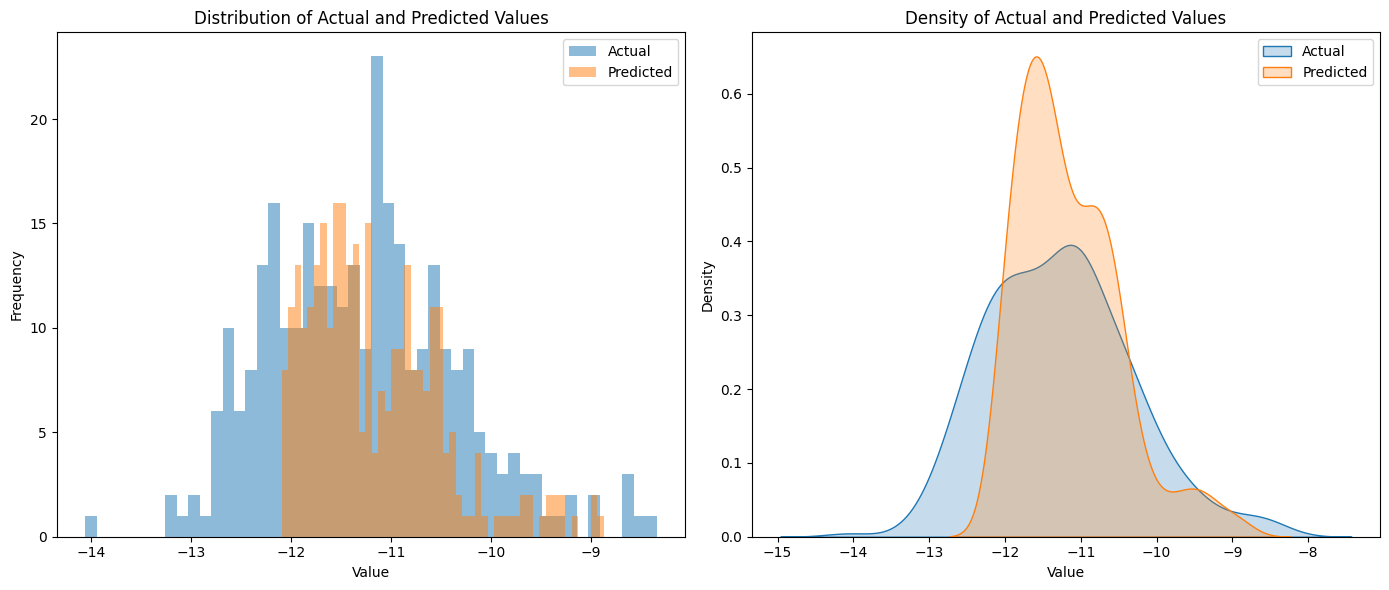

,Model,Val MSE,Val QLike
0,Tuned LSLTM,0.331615,0.001308


In [20]:
train_scaled, val_scaled, scaler = scale_data(train_rv, val_rv)
X_train, y_train, X_val, y_val = prepare_data(train_scaled, val_scaled)

# Assuming X_train and y_train are your full training dataset
final_lstm_1_model.fit(X_train, y_train, epochs=30, batch_size=32)  # Adjust epochs and batch_size as needed

# Assuming fold_X_val is your validation set features prepared for the LSTM input
predictions = final_lstm_1_model.predict(X_val)

fold_y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
predictions_actual = scaler.inverse_transform(predictions).flatten()

N = 300
plot_predictions_and_residuals(fold_y_val_actual[:N], predictions_actual[:N])
val_metrics(fold_y_val_actual, predictions_actual, 'Tuned LSLTM')

## 5.5 Holdout Set Predictions

Epoch 1/100
 35/111 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0328

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0330
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0331
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0331
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0331
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0331
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0331
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0331
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0331
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0330
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0330
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0330
Epoch 12/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0330
Epoch 13/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0330
Epoch 14/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0330
Epoch 15/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step 

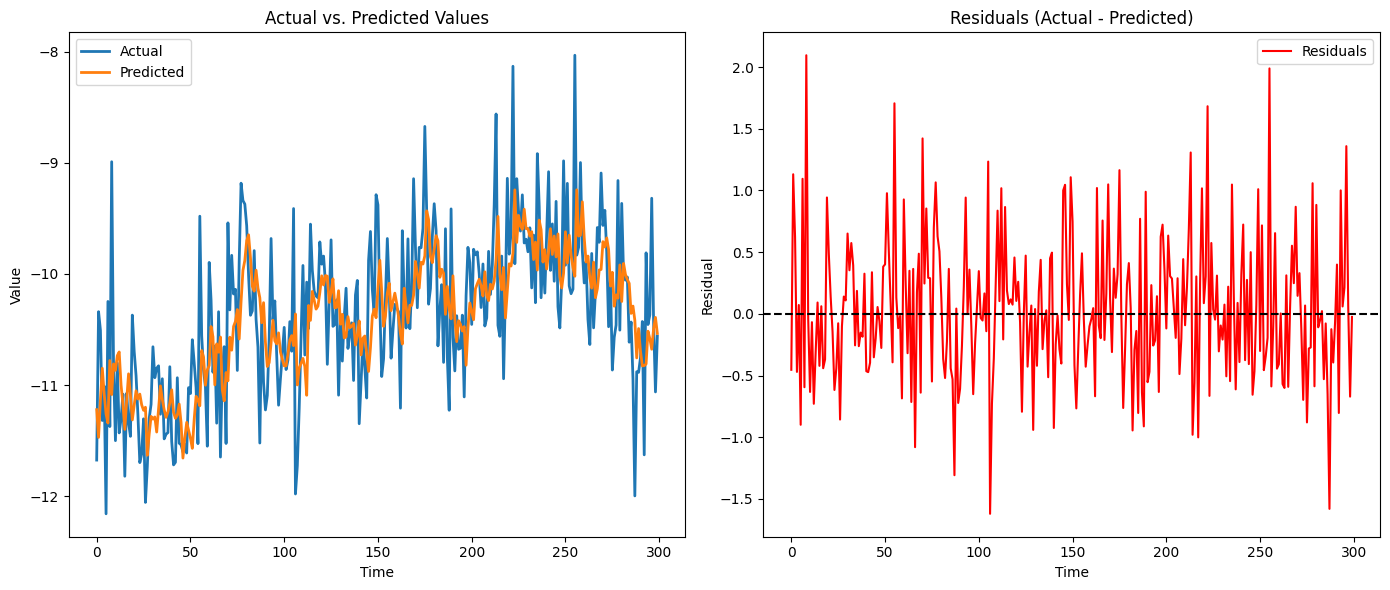

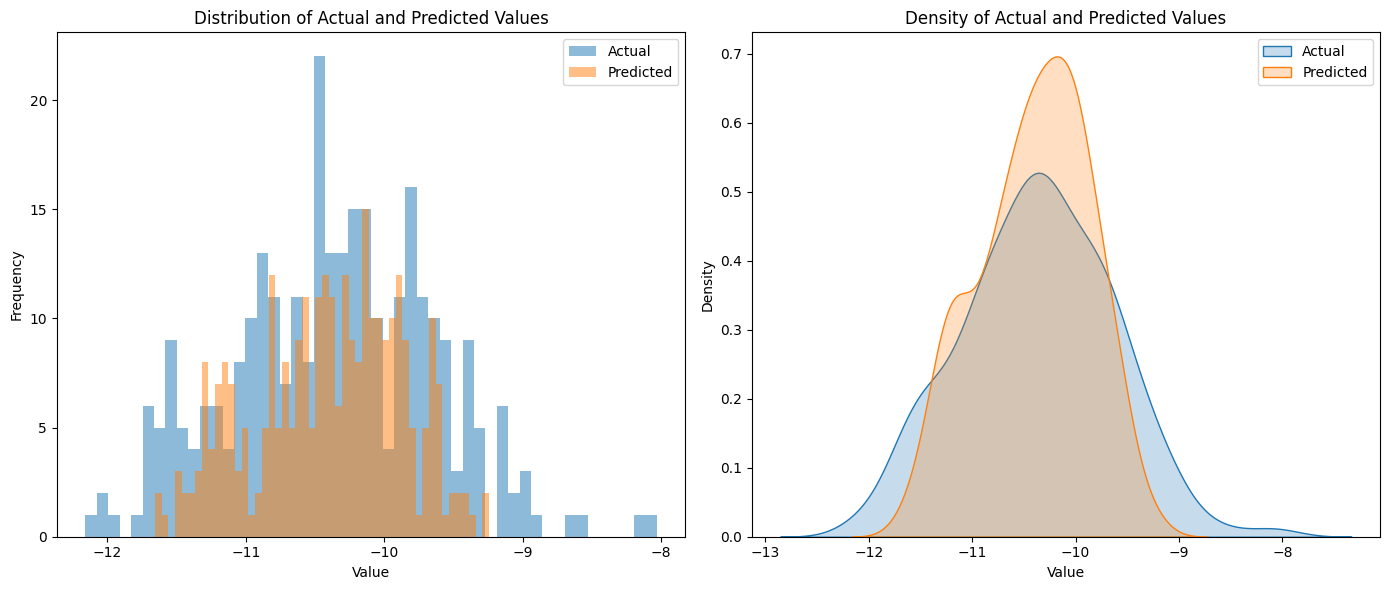

,Model,Test MSE,Test QLike
0,HAR Model,0.346003,0.001518
1,Tuned LSLTM,0.354405,0.001558


In [32]:
# combine train_rv and val_rv to train the model on the full training set
X_train_full = pd.concat([train_rv, val_rv])

train_scaled, holdout_scaled, lstm_scaler = scale_data(X_train_full, holdout_rv)
X_train, y_train, X_test, y_test = prepare_data(train_scaled, holdout_scaled)

# Assuming X_train and y_train are your full training dataset
final_lstm_1_model.fit(X_train, y_train, epochs=100, batch_size=32)  # Adjust epochs and batch_size as needed

# Assuming fold_X_val is your validation set features prepared for the LSTM input
predictions_lstm_1 = final_lstm_1_model.predict(X_test)

y_actual = lstm_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_preds_lstm_1 = lstm_scaler.inverse_transform(predictions_lstm_1).flatten()

N = 300
plot_predictions_and_residuals(y_actual[:N], y_preds_lstm_1[:N])
holdout_metrics(y_actual, y_preds_lstm_1, 'Tuned LSLTM')

## 5.6 DM Test Comparison with Baseline

In [33]:
actual = y_actual.squeeze()
pred_lstm_1 = y_preds_lstm_1.squeeze()

pred_baseline = har_y_holdout_pred[-len(y_preds_lstm_1):].values
pred_baseline = pred_baseline.squeeze()


dm_test(actual, pred_baseline, pred_lstm_1, h = 1, crit="QLIKE")

dm_return(DM=-6.83315959489339, p_value=2.008152993085875e-11)

# 6 LSTM-3

## 6.1 Functions

In [34]:
def create_sequences_tri(data, sequence_length=10):
    xs, ys = [], []
    num_features = data.shape[1]  # No change needed here, works for numpy arrays too
    for i in range(sequence_length, len(data)):
        # Adjust to use array slicing instead of .iloc
        xs.append(data[i-sequence_length:i].reshape((sequence_length, num_features)))
        # Adjust to access the target feature directly; assuming the first feature is the target
        ys.append(data[i, 0])
    return np.array(xs), np.array(ys)



def scale_data_tri(train_data, val_data):
    """
    Scale train and validation data with three features using individual MinMaxScalers.

    This function fits MinMaxScalers to the training data for each of the three features
    independently and then transforms both the training and validation datasets according
    to the fitted scalers. It is designed to normalize each feature to a specified range,
    which is essential for the effective training of neural networks. Only the scaler for
    the first feature (the target feature) is returned for future inverse transformations.

    Parameters:
    - train_data (pandas.DataFrame): Training dataset with three features.
    - val_data (pandas.DataFrame): Validation dataset with three features.

    Returns:
    - numpy.ndarray: Scaled training dataset with shape (n_samples, 3).
    - numpy.ndarray: Scaled validation dataset with shape (n_samples, 3).
    - MinMaxScaler: Fitted scaler object for the first feature for inverse transformation.
    """
    # Initialize scalers for each feature
    # scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(train_data.shape[1])]
    scalers = [MinMaxScaler(feature_range=(0, 1)) for _ in range(train_data.shape[1])]

    # Scale each feature independently
    train_scaled = np.hstack([scalers[i].fit_transform(train_data.values[:, i].reshape(-1, 1)) for i in range(train_data.shape[1])])
    val_scaled = np.hstack([scalers[i].transform(val_data.values[:, i].reshape(-1, 1)) for i in range(val_data.shape[1])])
    
    # Return the scaled data and only the scaler for the first feature
    return train_scaled, val_scaled, scalers[0]

def prepare_data_tri(scaled_train, scaled_val, number_of_features = 3):
    """
    Prepare data for LSTM training from scaled datasets.

    This function takes scaled training and validation datasets and converts them into
    sequences suitable for LSTM model training. It involves reshaping the data into a
    format that LSTM models can work with, which is [samples, time steps, features].

    Parameters:
    - scaled_train (numpy.ndarray): Scaled training data.
    - scaled_val (numpy.ndarray): Scaled validation data.
    - number_of_features (int): The number of features in the dataset.

    Returns:
    - numpy.ndarray: Reshaped training features suitable for LSTM input.
    - numpy.ndarray: Training labels.
    - numpy.ndarray: Reshaped validation features suitable for LSTM input.
    - numpy.ndarray: Validation labels.
    """
    X_train, y_train = create_sequences_tri(scaled_train)
    X_val, y_val = create_sequences_tri(scaled_val)
    # Correct reshaping to accommodate multiple features
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], number_of_features))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], number_of_features))
    return X_train, y_train, X_val, y_val


## 6.2 Train test Splot

In [35]:
train_tri = train_data[['RV_daily', 'RV_weekly', 'RV_monthly']]
val_tri = val_data[['RV_daily', 'RV_weekly', 'RV_monthly']]
holdout_tri = holdout_data[['RV_daily', 'RV_weekly', 'RV_monthly']]
print(train_tri.head())

             RV_daily  RV_weekly  RV_monthly
2008-04-17  -9.890641 -10.274476  -10.219443
2008-04-18  -9.857681 -10.167142  -10.215625
2008-04-21 -10.284721 -10.181152  -10.166403
2008-04-22  -9.856499 -10.021795  -10.149630
2008-04-23 -10.700541 -10.118017  -10.185868


## 6.3 Model Architecure

In [36]:
def create_lstm_3_model(input_shape):
    """
    Creates an LSTM model for multi-feature input.
    
    Parameters:
    - input_shape (tuple): Shape of the input data, including time steps and number of features.
    
    Returns:
    - A compiled Keras model suitable for multi-feature input.
    """
    model = Sequential()
    model.add(LSTM(units=64, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## 6.4 Cross Validation

In [37]:
tscv = TimeSeriesSplit(n_splits=3)
mse_vals = []
qlike_vals = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(train_tri)):
    print(f"Starting fold {fold+1}")

    # Splitting data into training and validation sets using the indices
    fold_train_data, fold_val_data = train_tri.iloc[train_idx], train_tri.iloc[val_idx]
    
    # Scale data with three features
    fold_train_scaled, fold_val_scaled, fold_scaler = scale_data_tri(fold_train_data, fold_val_data)
    
    # Prepare data for LSTM
    number_of_features = fold_train_data.shape[1]  # Assuming train_tri is your dataset
    fold_X_train, fold_y_train, fold_X_val, fold_y_val = prepare_data_tri(fold_train_scaled, fold_val_scaled, number_of_features)
    
    # Create and train the LSTM model
    fold_lstm_model = create_lstm_3_model((fold_X_train.shape[1], number_of_features))
    fold_history = fold_lstm_model.fit(fold_X_train, fold_y_train, epochs=100, batch_size=32, verbose=0, validation_data=(fold_X_val, fold_y_val))
    
    # Predict and inverse transform predictions
    predictions = fold_lstm_model.predict(fold_X_val)
    fold_y_pred = fold_scaler.inverse_transform(predictions)
    fold_y_actual = fold_scaler.inverse_transform(fold_y_val.reshape(-1, 1))

    # Calculate and append MSE
    mse = mean_squared_error(fold_y_actual, fold_y_pred)
    mse_vals.append(mse)

    #Calculate and append other metrics (e.g., QLIKE) as needed
    qlike = q_like(fold_y_actual, fold_y_pred)  # Assuming this function is defined elsewhere
    qlike_vals.append(qlike)

    print(f"Fold {fold+1} MSE: {mse}")
    print(f"Fold {fold+1} QLIKE: {qlike}")

    # # Plot training and validation loss
    # plt.figure(figsize=(10, 4))
    # plt.plot(fold_history.history['loss'], label='Training Loss')
    # plt.plot(fold_history.history['val_loss'], label='Validation Loss')
    # plt.title(f'Fold {fold+1} Training and Validation Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.show()

avg_mse = np.mean(mse_vals)
avg_qlike = np.mean(qlike_vals)

print(f"Average MSE: {avg_mse}")
print(f"Average QLIKE: {avg_qlike}")

Starting fold 1


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 1 MSE: 0.31873214086711954
Fold 1 QLIKE: 0.00142895738232948
Starting fold 2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 2 MSE: 0.43462203104072417
Fold 2 QLIKE: 0.0019149637420389943
Starting fold 3
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 3 MSE: 0.35308333090514
Fold 3 QLIKE: 0.0014442418969420774
Average MSE: 0.36881250093766127
Average QLIKE: 0.0015960543404368508


### Double Layer CV

In [38]:
def create_lstm_3_double_model(input_shape):
    """
    Creates an LSTM model for multi-feature input.
    
    Parameters:
    - input_shape (tuple): Shape of the input data, including time steps and number of features.
    
    Returns:
    - A compiled Keras model suitable for multi-feature input.
    """
    model = Sequential()
    model.add(LSTM(units=64, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units=64))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [39]:
tscv = TimeSeriesSplit(n_splits=3)
mse_vals = []
qlike_vals = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(train_tri)):
    print(f"Starting fold {fold+1}")

    # Splitting data into training and validation sets using the indices
    fold_train_data, fold_val_data = train_tri.iloc[train_idx], train_tri.iloc[val_idx]
    
    # Scale data with three features
    fold_train_scaled, fold_val_scaled, fold_scaler = scale_data_tri(fold_train_data, fold_val_data)
    
    # Prepare data for LSTM
    number_of_features = fold_train_data.shape[1]  # Assuming train_tri is your dataset
    fold_X_train, fold_y_train, fold_X_val, fold_y_val = prepare_data_tri(fold_train_scaled, fold_val_scaled, number_of_features)
    
    # Create and train the LSTM model
    fold_lstm_model = create_lstm_3_double_model((fold_X_train.shape[1], number_of_features))
    fold_history = fold_lstm_model.fit(fold_X_train, fold_y_train, epochs=100, batch_size=32, verbose=0, validation_data=(fold_X_val, fold_y_val))
    
    # Predict and inverse transform predictions
    predictions = fold_lstm_model.predict(fold_X_val)
    fold_y_pred = fold_scaler.inverse_transform(predictions)
    fold_y_actual = fold_scaler.inverse_transform(fold_y_val.reshape(-1, 1))

    # Calculate and append MSE
    mse = mean_squared_error(fold_y_actual, fold_y_pred)
    mse_vals.append(mse)

    #Calculate and append other metrics (e.g., QLIKE) as needed
    qlike = q_like(fold_y_actual, fold_y_pred)  # Assuming this function is defined elsewhere
    qlike_vals.append(qlike)

    print(f"Fold {fold+1} MSE: {mse}")
    print(f"Fold {fold+1} QLIKE: {qlike}")

    # # Plot training and validation loss
    # plt.figure(figsize=(10, 4))
    # plt.plot(fold_history.history['loss'], label='Training Loss')
    # plt.plot(fold_history.history['val_loss'], label='Validation Loss')
    # plt.title(f'Fold {fold+1} Training and Validation Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.legend()
    # plt.show()

avg_mse = np.mean(mse_vals)
avg_qlike = np.mean(qlike_vals)

print(f"Average MSE: {avg_mse}")
print(f"Average QLIKE: {avg_qlike}")

Starting fold 1
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 1 MSE: 0.3320511697123061
Fold 1 QLIKE: 0.0014914614881507715
Starting fold 2
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 2 MSE: 0.4372398521701837
Fold 2 QLIKE: 0.0019262618956861885
Starting fold 3
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 3 MSE: 0.34644537039350914
Fold 3 QLIKE: 0.0014170902128777909
Average MSE: 0.3719121307586663
Average QLIKE: 0.0016116045322382502


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


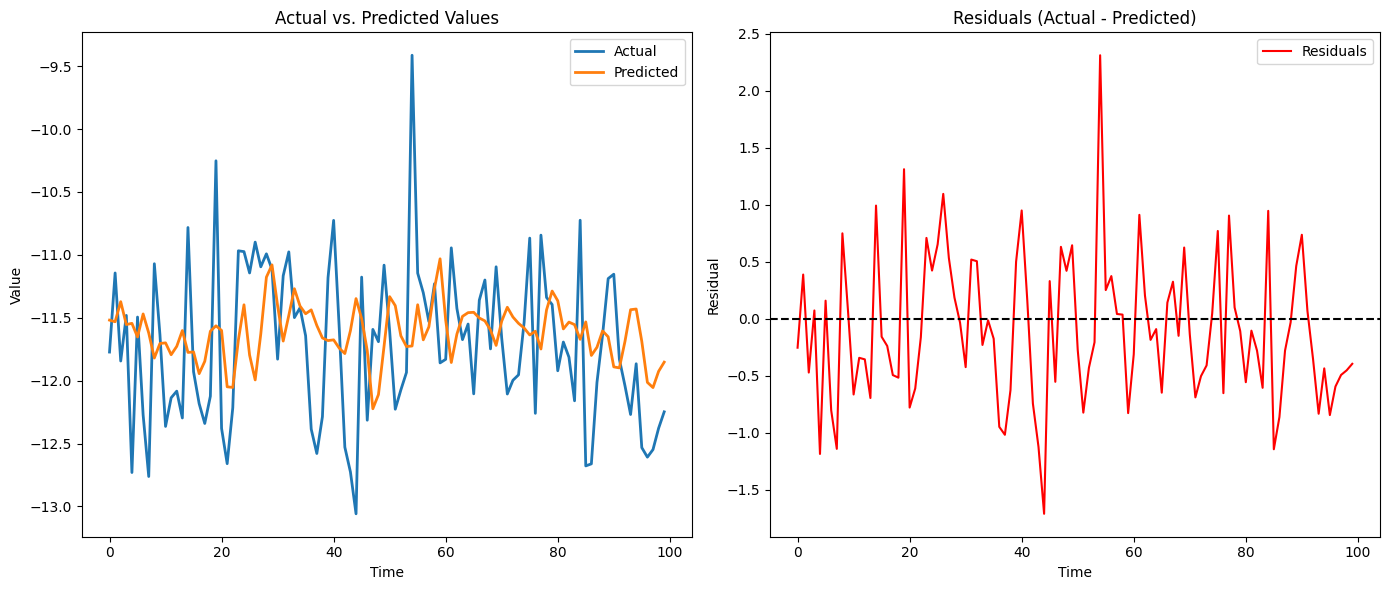

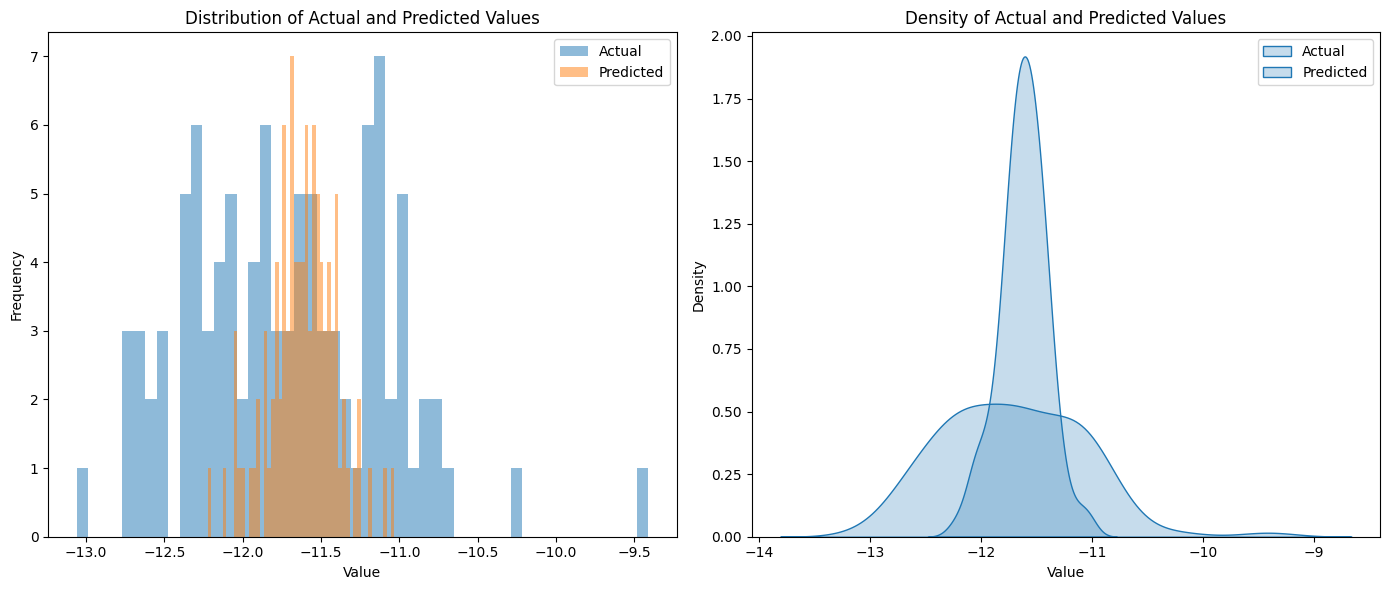

In [40]:
# make predictions on val set
# Scale data with three features
train_scaled, val_scaled, lstm_scaler = scale_data_tri(train_tri, val_tri)

# Prepare data for LSTM
number_of_features = train_tri.shape[1]  # Assuming train_tri is your dataset
X_train, y_train, X_val, y_val = prepare_data_tri(train_scaled, val_scaled, number_of_features)

# Create and train the LSTM model
lstm_model = create_lstm_3_double_model((X_train.shape[1], number_of_features))
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Predict and inverse transform predictions
predictions_lstm_3 = lstm_model.predict(X_val)
y_preds_lstm_3 = lstm_scaler.inverse_transform(predictions_lstm_3)
y_actual = lstm_scaler.inverse_transform(y_val.reshape(-1, 1))

N = 100
plot_predictions_and_residuals(y_actual[:N], y_preds_lstm_3[:N])

In [41]:
val_metrics(y_actual, y_preds_lstm_3, 'LSTM 3 Features Standard Scaler Linear output')

,Model,Val MSE,Val QLike
0,HAR,0.317410,0.001268
1,Tuned LSLTM,0.324110,0.001281
2,LSTM 3 Features Standard Scaler Linear output,0.322971,0.001286


## 6.5 Hyper Parameter Tuning 

### 6.5.1 Model and Class

In [42]:
def create_lstm_3_model(input_shape, units = 64, learning_rate=0.001, dropout_rate=0.0):
    """
    Creates an LSTM model for multi-feature input.
    
    Parameters:
    - input_shape (tuple): Shape of the input data, including time steps and number of features.
    
    Returns:
    - A compiled Keras model suitable for multi-feature input.
    """
    model = Sequential()
    model.add(LSTM(units=units, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [43]:
class LSTMTriHyperModel(HyperModel):
    def __init__(self, input_shape, num_features):
        self.input_shape = input_shape
        self.num_features = num_features

    def build(self, hp):
        units = hp.Int('units', min_value=50, max_value=250, step=50)
        dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        # kernel_initializer = hp.Choice('kernel_initializer', values=['glorot_uniform', 'he_normal'])
        model = create_lstm_3_model(
            input_shape=self.input_shape, 
            units=units, 
            learning_rate=learning_rate, 
            dropout_rate=dropout_rate,
            # kernel_initializer=kernel_initializer
        )
        return model

### 5.1.2 Tuning with CV

In [44]:
from collections import defaultdict
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import os, shutil
from kerastuner.tuners import Hyperband


tscv = TimeSeriesSplit(n_splits=3)
performance_summary = defaultdict(lambda: {'sum': 0, 'count': 0})

input_shape = (look_back, 3)  # Adjust based on your dataset specifics
hyper_lstm_model = LSTMTriHyperModel(input_shape=input_shape, num_features=3)

for fold, (train_idx, val_idx) in enumerate(tscv.split(train_tri)):
    print(f"Starting fold {fold+1}")
    
    fold_train_data, fold_val_data = train_tri.iloc[train_idx], train_tri.iloc[val_idx]
    train_scaled, val_scaled, scaler = scale_data_tri(fold_train_data, fold_val_data)
    fold_X_train, fold_y_train, fold_X_val, fold_y_val = prepare_data_tri(train_scaled, val_scaled, 3)
    
    tuner_directory = f'lstm_tuning_fold_{fold+1}'
    project_name = 'time_series_prediction_3feat'
    shutil.rmtree(os.path.join(tuner_directory, project_name), ignore_errors=True)

    tuner = Hyperband(
        hypermodel=hyper_lstm_model,
        objective='val_loss',
        max_epochs=50,
        factor=3,
        directory=tuner_directory,
        project_name=project_name
    )
    
    tuner.search(
        fold_X_train, fold_y_train,
        epochs=100,
        validation_data=(fold_X_val, fold_y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10)],
        verbose=2
    )
    
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]
    predictions = best_model.predict(fold_X_val)
    fold_y_pred = scaler.inverse_transform(predictions.reshape(-1, 1))
    fold_y_actual = scaler.inverse_transform(fold_y_val.reshape(-1, 1))
    q_like_score = q_like(fold_y_actual, fold_y_pred)
    mse = mean_squared_error(fold_y_actual, fold_y_pred)

    # Hyperparameter identifier adjustment
    hyperparams_id = f"{best_hp.get('units')}_{best_hp.get('dropout_rate')}_{best_hp.get('learning_rate')}"

    performance_summary[hyperparams_id]['sum'] += q_like_score
    performance_summary[hyperparams_id]['count'] += 1

best_hyperparams_id, best_metrics = min(performance_summary.items(), key=lambda x: x[1]['sum'] / x[1]['count'])
units, dropout_rate, learning_rate = best_hyperparams_id.split('_')

print(f"Best Hyperparameters: units={units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, Average Q-Like: {best_metrics['sum'] / best_metrics['count']}")

# Create best model
final_lstm_3_model = create_lstm_3_model(
    input_shape=input_shape, 
    units=int(units), 
    dropout_rate=float(dropout_rate), 
    learning_rate=float(learning_rate)
)


Trial 90 Complete [00h 01m 50s]
val_loss: 0.00908693764358759

Best val_loss So Far: 0.008801410906016827
Total elapsed time: 00h 14m 39s
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Best Hyperparameters: units=200, dropout_rate=0.1, learning_rate=0.005964840236066948, Average Q-Like: 0.0012968073561013364


### evaluate tuned model on val 

In [45]:
# fit scaler on the full training data
train_scaled, val_scaled, scaler = scale_data_tri(train_tri, val_tri)
X_train, y_train, X_val, y_val = prepare_data_tri(train_scaled, val_scaled, 3)

# fit the model on the full training data
final_lstm_3_model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

# predict on the validation set
predictions = final_lstm_3_model.predict(X_val)
y_actual = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

# inverse transform the predictions
y_pred = scaler.inverse_transform(predictions).flatten()

N = 300

Epoch 1/100


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0556
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0092
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0090
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0089
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0088
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0089
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0088
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0090
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0089
Epoch 10/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0087
Epoch 11/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0088
Epoch 12/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0088
Epoch 13/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0088
Epoch 14/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0087
Epoch 15/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0089
E

## 6.6 Holdout Set Predictions 

Epoch 1/100


111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0085
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0085
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0086
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0085
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0086
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0084
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0085
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0084
Epoch 9/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0084
Epoch 10/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0084
Epoch 11/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0085
Epoch 12/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0083
Epoch 13/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0085
Epoch 14/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0083
Epoch 15/100
111/111 ━━━━━━━━━━━━━━━━━━━━

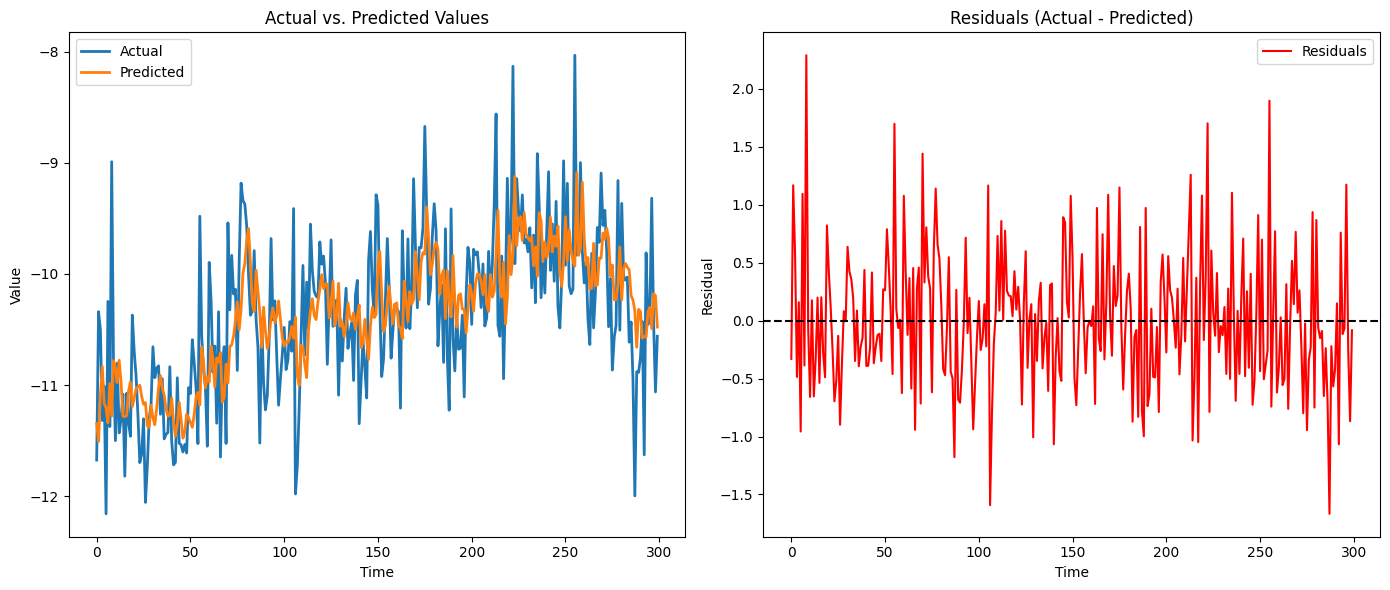

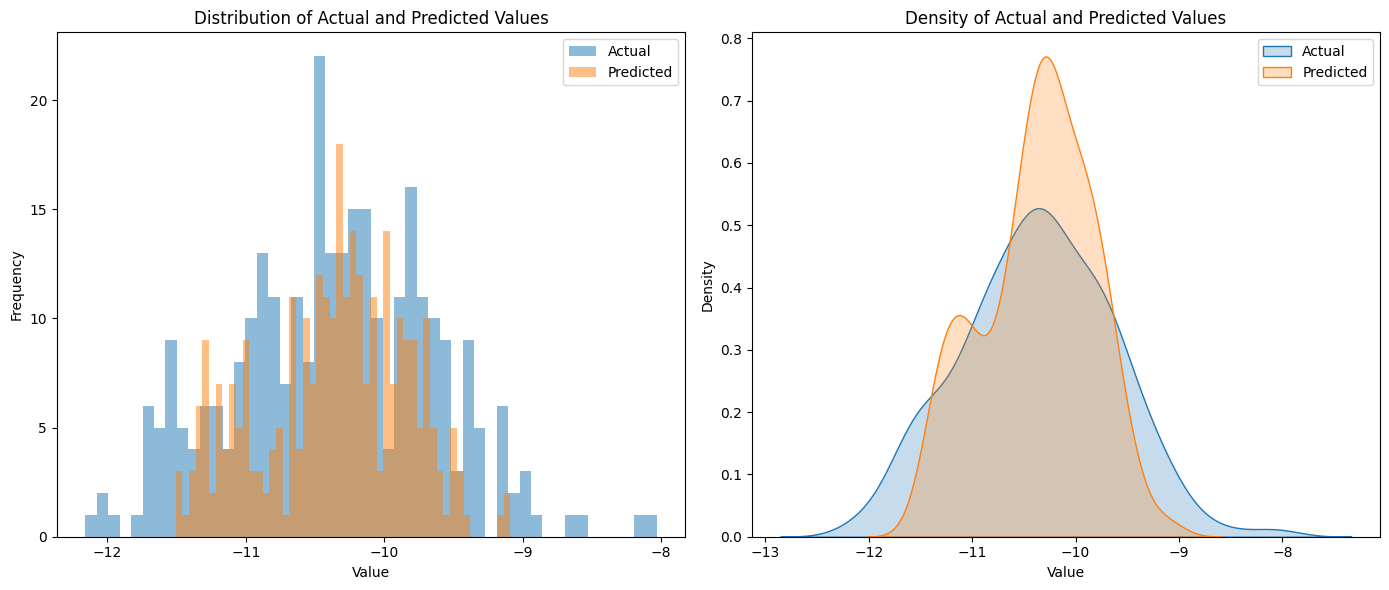

,Model,Test MSE,Test QLike
0,HAR Model,0.346003,0.001518
1,Tuned LSLTM,0.354405,0.001558
2,"Standard(0,1) linear LSTM 3 Features",0.347032,0.001533


In [46]:
# combine train_rv and val_rv to train the model on the full training set
X_train_full = pd.concat([train_tri, val_tri])

train_scaled, holdout_scaled, lstm_scaler = scale_data_tri(X_train_full, holdout_tri)
X_train, y_train, X_test, y_test = prepare_data_tri(train_scaled, holdout_scaled)

# Assuming X_train and y_train are your full training dataset
final_lstm_3_model.fit(X_train, y_train, epochs=100, batch_size=32)  # Adjust epochs and batch_size as needed

# Assuming fold_X_val is your validation set features prepared for the LSTM input
predictions_lstm_3 = final_lstm_3_model.predict(X_test)

y_actual = lstm_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

y_preds_lstm_3 = lstm_scaler.inverse_transform(predictions_lstm_3).flatten()

N = 300
plot_predictions_and_residuals(y_actual[:N], y_preds_lstm_3[:N])
holdout_metrics(y_actual, y_preds_lstm_3, 'Standard(0,1) linear LSTM 3 Features')

# EVALUATIONS 

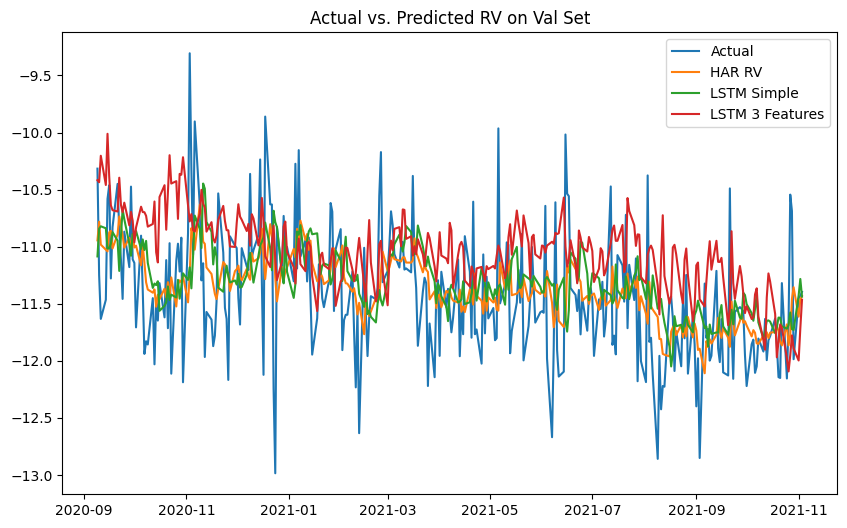

In [48]:
plt.figure(figsize=(10, 6))

length = 300

plt.plot(har_y_val_pred.index[-length:], y_val_har[-length:], label = 'Actual')
plt.plot(har_y_val_pred.index[-length:], har_y_val_pred[-length:], label = 'HAR RV')
plt.plot(har_y_val_pred.index[-length:], predictions_actual[-length:], label = 'LSTM Simple')
plt.plot(har_y_val_pred.index[-length:], y_preds_lstm_3[-length:], label = 'LSTM 3 Features')
# plt.plot(har_y_val_pred.index[-len(val_pred_nn1_inverse):], val_preds_mlp_inverse, label = 'MLP')
# plt.plot(har_y_val_pred.index[-len(val_pred_nn1_inverse):], val_preds_tri_inverse[-len(val_pred_nn1_inverse):], label = 'Tripe LSTM')
# plt.plot(har_y_val_pred.index[-len(val_pred_nn1_inverse):], val_preds_ed_inverse[-len(val_pred_nn1_inverse):], label = 'ed LSTM')


plt.legend()
plt.title('Actual vs. Predicted RV on Val Set')
plt.show()